In [1]:
!pip install dython imbalanced-learn xgboost
!pip install scikit-learn imbalanced-learn xgboost dython
%load_ext autoreload
%autoreload 2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, clear_output
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from dython.nominal import associations

import pickle
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

In [3]:
def load_OU_data(prediction_window=None):
    # Load data
    assessments = pd.read_csv('/content/my dataset/assessments.csv').drop_duplicates()
    courses = pd.read_csv('/content/my dataset/courses.csv').drop_duplicates()
    student_assessment = pd.read_csv('/content/my dataset/studentAssessment.csv').drop_duplicates()
    student_info = pd.read_csv('/content/my dataset/studentInfo.csv').drop_duplicates()
    student_registration = pd.read_csv('/content/my dataset/studentRegistration.csv').drop_duplicates()
    student_vle = pd.read_csv('/content/my dataset/studentVle.csv').drop_duplicates()
    vle = pd.read_csv('/content/my dataset/vle.csv').drop_duplicates()

    index_columns = ['code_module', 'code_presentation', 'id_student']

    # Ensure 'id_student' is present and correctly named
    for df in [student_assessment, student_info, student_registration, student_vle]:
        if 'id_student' not in df.columns:
            raise KeyError("The column 'id_student' is missing from one of the dataframes.")

    # Registrations
    full_registrations = pd.merge(student_info, student_registration, on=index_columns, validate='1:1')
    full_registrations = pd.merge(full_registrations, courses, on=['code_module', 'code_presentation'], validate='many_to_one')
    full_registrations.dropna(subset=['date_registration', 'imd_band'], inplace=True)

    not_withdrawn = full_registrations['date_unregistration'].isna()

    if type(prediction_window) == float:
        prediction_window = prediction_window * (full_registrations.module_presentation_length.min())
    if prediction_window:
        withdrawn_after_predict = (full_registrations['final_result'] == 'Withdrawn') & (full_registrations['date_unregistration'] > prediction_window)
    else:
        withdrawn_after_predict = (full_registrations['final_result'] == 'Withdrawn') & (full_registrations['date_unregistration'] > 0)
    full_registrations = full_registrations[not_withdrawn | withdrawn_after_predict]
    full_registrations['date_unregistration'].fillna(full_registrations['module_presentation_length'], inplace=True)
    full_registrations = full_registrations[full_registrations['date_unregistration'] <= full_registrations['module_presentation_length']]
    if prediction_window:
        full_registrations.drop(columns=['date_unregistration'], inplace=True)

    # VLE
    if prediction_window:
        student_vle = student_vle[student_vle.date <= prediction_window]
    vle = pd.merge(student_vle, vle, how='left', on=['id_site', 'code_module', 'code_presentation'], validate='m:1').drop(columns=['week_from', 'week_to'])

    total_activities = vle.groupby(by=index_columns).count().reset_index()
    total_activities = total_activities.drop(columns=['date', 'sum_click', 'activity_type'])

    date_grouped = vle.groupby(by=index_columns + ['date']).count().reset_index()
    days_studied = date_grouped.groupby(by=index_columns).count().reset_index()
    days_studied = days_studied.drop(columns=['id_site', 'sum_click', 'activity_type'])

    clicks = vle.groupby(by=index_columns).sum().reset_index()
    clicks = clicks.drop(columns=['id_site', 'date'])

    full_registrations = pd.merge(full_registrations, days_studied, on=index_columns, how='left')
    full_registrations = pd.merge(full_registrations, total_activities, on=index_columns, how='left')
    full_registrations = pd.merge(full_registrations, clicks, on=index_columns, how='left')

    # Assessments
    assessments = pd.merge(student_assessment, assessments, how='left', on='id_assessment')
    assessments.dropna(subset=['score'], inplace=True)
    assessments.drop(columns=['is_banked'], inplace=True)
    if prediction_window:
        assessments = assessments[assessments['date_submitted'] <= prediction_window]

    # Convert relevant columns to numeric, handling non-numeric values
    assessments['score'] = pd.to_numeric(assessments['score'], errors='coerce')
    assessments['date_submitted'] = pd.to_numeric(assessments['date_submitted'], errors='coerce')
    assessments['weight'] = pd.to_numeric(assessments['weight'], errors='coerce')

    num_assessments = assessments.groupby(by=index_columns).count().reset_index()
    num_assessments.rename(columns={'id_student_x': 'id_student'}, inplace=True)  # Rename to match index_columns
    total_assessments = assessments.groupby(by=['code_module', 'code_presentation']).count().reset_index()
    total_assessments = total_assessments.drop(columns=['assessment_type', 'date', 'weight'])
    total_assessments = total_assessments.rename(columns={'id_assessment': 'total_assessments'})
    num_assessments = pd.merge(num_assessments, total_assessments, how='left', on=['code_module', 'code_presentation'])
    num_assessments['id_assessment'] = num_assessments['id_assessment'] / num_assessments['total_assessments']

    num_assessments.drop(columns=['total_assessments', 'date', 'assessment_type'], inplace=True)

    avg_score = assessments.groupby(by=index_columns).mean(numeric_only=True).reset_index()
    avg_score.drop(columns=['id_assessment', 'date'], inplace=True)

    # Ensure that 'id_student' is present in all DataFrames involved in the merge
    if 'id_student_x' in num_assessments.columns:
        num_assessments.rename(columns={'id_student_x': 'id_student'}, inplace=True)
    if 'id_student_y' in num_assessments.columns:
        num_assessments.drop(columns=['id_student_y'], inplace=True)

    # Assuming 'id_student' is present, the merge operation should work:
    full_registrations = pd.merge(full_registrations, num_assessments, on=index_columns, how='left')
    full_registrations = pd.merge(full_registrations, avg_score, on=index_columns, how='left')
    full_registrations = full_registrations.fillna(value=0)

    # Rename columns
    new_cols = {'id_assessment': 'assessments_completed', 'score': 'average_assessment_score', 'date': 'days_studied', 'id_site': 'activities_engaged', 'sum_click': 'total_clicks'}
    full_registrations = full_registrations.rename(columns=new_cols)
    full_registrations = full_registrations[(full_registrations['total_clicks'] < 4035) & (full_registrations['activities_engaged'] < 1135)]
    return full_registrations

# Ensure to load data properly
from google.colab import drive
drive.mount('/content/drive')

my_data = load_OU_data(prediction_window=None)
my_data.head(20)
my_data.tail(20)

Mounted at /content/drive


code_module code_presentation  id_student gender                region  \
28410         GGG             2014J     2271766      F         London Region   
28411         GGG             2014J     2282141      M                 Wales   
28412         GGG             2014J     2311714      F         London Region   
28413         GGG             2014J     2338614      F              Scotland   
28414         GGG             2014J     2342238      M               Ireland   
28415         GGG             2014J     2357806      F               Ireland   
28416         GGG             2014J     2373245      M  East Midlands Region   
28417         GGG             2014J     2378591      F  West Midlands Region   
28418         GGG             2014J     2456431      F          South Region   
28419         GGG             2014J     2475886      F   East Anglian Region   
28420         GGG             2014J     2508153      F  East Midlands Region   
28421         GGG             2014J     2533195      F     South East Region   
28422         GGG             2014J     2606765      F         London Region   
28423         GGG             2014J     2608143      M  East Midlands Region   
28424         GGG             2014J     2620947      F              Scotland   
28425         GGG             2014J     2640965      F                 Wales   
28426         GGG             2014J     2645731      F   East Anglian Region   
28427         GGG             2014J     2648187      F          South Region   
28428         GGG             2014J     2679821      F     South East Region   
28429         GGG             2014J     2684003      F      Yorkshire Region   

           highest_education imd_band age_band  num_of_prev_attempts  \
28410  A Level or Equivalent   30-40%    35-55                     0   
28411  A Level or Equivalent    0-10%    35-55                     0   
28412     Lower Than A Level   30-40%    35-55                     0   
28413  A Level or Equivalent    0-10%    35-55                     0   
28414       HE Qualification   80-90%     0-35                     0   
28415     Lower Than A Level   40-50%    35-55                     0   
28416     Lower Than A Level   20-30%    35-55                     0   
28417  A Level or Equivalent   30-40%    35-55                     1   
28418     Lower Than A Level   70-80%     0-35                     0   
28419     Lower Than A Level   40-50%    35-55                     0   
28420     Lower Than A Level    10-20     0-35                     0   
28421     Lower Than A Level    10-20     0-35                     0   
28422     Lower Than A Level   80-90%     0-35                     0   
28423       HE Qualification   60-70%    35-55                     0   
28424  A Level or Equivalent   80-90%     0-35                     0   
28425     Lower Than A Level    10-20     0-35                     0   
28426     Lower Than A Level   40-50%    35-55                     0   
28427  A Level or Equivalent   20-30%     0-35                     0   
28428     Lower Than A Level  90-100%    35-55                     0   
28429       HE Qualification   50-60%    35-55                     0   

       studied_credits  ...  \
28410               30  ...   
28411               60  ...   
28412               30  ...   
28413               30  ...   
28414               30  ...   
28415               30  ...   
28416               30  ...   
28417               30  ...   
28418               30  ...   
28419               90  ...   
28420               30  ...   
28421               30  ...   
28422               30  ...   
28423               30  ...   
28424               30  ...   
28425               30  ...   
28426               30  ...   
28427               30  ...   
28428               30  ...   
28429               30  ...   

                                           activity_type  \
28410  oucontenthomepageresourcehomepageforumngforumn...   
28411  resourcehomepageoucontentouconten

In [4]:
class CourseScaler(TransformerMixin, BaseEstimator):
    def __init__(self, drop_course=True):
        self.drop_course = drop_course
        pass

    def fit(self,X,y=None):
        self.cols = X.select_dtypes(include = 'number').columns
        if len(self.cols) == 0:
            print('No columns to standardize')
            return self
        else:
            modules = X['code_module'].unique()
            self.means = pd.DataFrame(index = modules, columns = self.cols)
            self.stds = pd.DataFrame(index = modules, columns = self.cols)
            for module in modules:
                course_X = X[X['code_module'] == module]
                for col in self.cols:
                    self.means.loc[module, col] = course_X[col].mean()
                    self.stds.loc[module, col] = course_X[col].std() + 1e-10
            return self

    def transform(self,X,y=None):
        if not hasattr(self,'means'):
            print('WARNING: transformer Not yet fit')
            return self
        else:
            i = X.index
            X.reset_index(drop = True, inplace = True)
            scaled_X = pd.DataFrame()
            for module in self.means.index:
                course_X = X[X['code_module'] == module]
                for col in self.means.columns:
                    mean = self.means.loc[module,col]
                    std = self.stds.loc[module,col]
                    course_X[col] = (course_X[col] - mean)/std
                scaled_X = pd.concat([scaled_X,course_X], axis = 0)
            scaled_X.sort_index(inplace = True)
            scaled_X.index = i
            scaled_X.fillna(value = 0, inplace = True)
            if self.drop_course:
                scaled_X.drop('code_module', axis = 1, inplace = True)
            return scaled_X

In [5]:
def smotecourses(X,y,drop_course=True):
    X['label'] = y
    smoted_X = pd.DataFrame()
    smoted_y = pd.DataFrame()
    for module in X['code_module'].unique():
        course_df = X[X['code_module'] == module]
        if len(course_df) > 0:
            course_X = course_df.drop(columns = ['label','code_module'])
            course_y = course_df['label']
            columns = course_X.columns
            course_X, course_y = SMOTE(random_state=111).fit_resample(course_X,course_y)
            course_X = pd.DataFrame(course_X, columns = columns)
            if not drop_course:
                course_X['code_module'] = module
            course_y = pd.Series(course_y)
            smoted_X = pd.concat([smoted_X, course_X], axis=0)
            smoted_y = pd.concat([smoted_y, course_y], axis=0)
    smoted_X.fillna(value = 0, inplace = True)
    return smoted_X, smoted_y


In [6]:
def process_courses(X_train, y_train, X_test, y_test=None):
    cs = CourseScaler(drop_course=False)
    X_train = cs.fit_transform(X_train)
    X_test = cs.transform(X_test)
    X_train, y_train = smotecourses(X_train, y_train, drop_course = True)
    X_test = X_test.drop(columns = ['code_module'])
    if type(y_test) == type(None):
        return X_train, y_train, X_test
    else:
        return X_train, y_train, X_test, y_test

In [7]:
def course_cross_validate(estimator,X,y,scoring='accuracy', cv=5, random_state = 111):
    if type(cv) == int:
        kf = KFold(n_splits = cv, shuffle=True, random_state=random_state)
    else:
        kf = cv
    scores = []
    y = np.array(y)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train, X_test = process_courses(X_train, y_train, X_test)
        estimator.fit(X_train,y_train)
        y_pred = estimator.predict(X_test)
        if scoring == 'accuracy':
            from sklearn.metrics import accuracy_score
            scores.append(accuracy_score(y_test,y_pred))
        elif scoring == 'f1':
            from sklearn.metrics import f1_score
            scores.append(f1_score(y_test,y_pred))
    return scores

In [8]:
class Course_GridSearchCV():
    def __init__(self, estimator, params, cv=5, scoring='accuracy', verbose = False):
        self.estimator = estimator
        self.paramgrid = ParameterGrid(params)
        self.cv = cv
        self.scoring = scoring
        self.verbose = verbose

    def fit(self,X,y):
        self.best_score_ = 0
        for params in self.paramgrid:
            if self.verbose:
                print('trying:')
                print(params)
            self.estimator.set_params(**params)
            scores = course_cross_validate(self.estimator, X, y, scoring=self.scoring, cv=self.cv)
            new_score = np.mean(scores)
            if self.verbose:
                print('average score: ', new_score)
            if new_score > self.best_score_:
                self.best_cv_ = scores
                self.best_score_ = new_score
                self.best_params_ = params
                self.best_estimator_ = self.estimator

In [9]:
def cross_val_presentation(model, df, scoring='accuracy', verbose=0):
    import pandas as pd
    index = df.groupby(by=['code_module','code_presentation']).count().index
    scores = pd.DataFrame(columns = ['score'], index = index)
    for module in df['code_module'].unique():
        df_course = df[df['code_module'] == module]
        for presentation in df_course['code_presentation'].unique():
            train = df[(df['code_module'] != module) | (df['code_presentation'] != presentation)]
            test = df[(df['code_module'] == module) & (df['code_presentation'] == presentation)]
            if module in train['code_module'].unique():
                score = model_evaluate_presentation(model, train, test, scoring='accuracy')
                scores.loc[(module,presentation), 'score'] = score
                if verbose > 1:
                    print((module,presentation))
            else:
                scores.loc[(module,presentation), 'score'] = np.nan
    if verbose > 0:
        display(scores.score.mean())
    return scores

In [10]:
def model_evaluate_presentation(model, train, test, scoring='accuracy'):
    from sklearn.metrics import accuracy_score, f1_score

    X_train = train.drop(columns = ['final_result', 'code_presentation'])
    y_train = train['final_result']
    X_test = test.drop(columns = ['final_result', 'code_presentation'])
    y_test = test['final_result']

    transformed_big_data = process_courses(X_train, y_train, X_test, y_test)
    X_train_transformed, y_train_transformed, X_test_transformed, y_test = transformed_big_data
    model.fit(X_train_transformed, y_train_transformed)
    y_pred = model.predict(X_test_transformed)
    if scoring == 'accuracy':
        return accuracy_score(y_test, y_pred)
    if scoring == 'f1':
        return f1_score(y_test, y_pred, pos_label = 'Needs Intervention')

In [11]:
class GridSearchPresentationCV():
    def __init__(self, estimator, params, scoring='accuracy', verbose = 0):
        from sklearn.model_selection import ParameterGrid

        self.estimator = estimator
        self.paramgrid = ParameterGrid(params)
        self.scoring = scoring
        self.verbose = verbose

    def fit(self, df, show_progress = False):
        self.best_score_ = 0
        for params in self.paramgrid:
            if self.verbose:
                print('trying:')
                print(params)
            self.estimator.set_params(**params)
            scores = cross_val_presentation(self.estimator, df, scoring=self.scoring)
            new_score = np.mean(scores.score)
            if self.verbose == 1:
                print('average score: ', new_score)
            if new_score > self.best_score_:
                self.best_cv_ = scores
                self.best_score_ = new_score
                self.best_params_ = params
                self.best_estimator_ = self.estimator

In [12]:
def plot_confusion(y_true, y_pred, encoder=None, labels=None, ax=None, cmap='Greens', save_path=None):
    from seaborn import heatmap
    from sklearn.metrics import confusion_matrix
    from matplotlib.pyplot import savefig
    if encoder:
            y_true = encoder.inverse_transform(y_true)
            y_pred = encoder.inverse_transform(y_pred)
    elif encoder:
        if not labels:
            labels = encoder.classes_
    if not labels:
        labels = np.unique(y_true)
    matrix = heatmap(confusion_matrix(y_true, y_pred, normalize = 'true', labels = labels),
                    annot = True, cmap = cmap, xticklabels = labels, yticklabels = labels, ax=ax)
    if save_path:
        savefig(save_path, dpi=250)
    return matrix

In [13]:
def score_grid(grid,X_val,y_val, labels=None, save_path=None, cmap='Greens', scoring='accuracy'):
    import seaborn as sns
    from sklearn.metrics import accuracy_score, f1_score
    from IPython.display import display
    score = grid.best_score_
    model = grid.best_estimator_
    print('best model')
    print(model)
    print('best cv')
    display(grid.best_cv_)
    print('cross validated accuracy score:')
    print(score)
    y_pred = model.predict(X_val)
    print(f'validation {scoring}: ')
    if scoring == 'accuracy':
        print(accuracy_score(y_val, y_pred))
    if scoring == 'f1':
        print(f1_score(y_val, y_pred))
    print('validation set confusion matrix')
    plot_confusion(y_val, y_pred, labels=labels, save_path=save_path, cmap=cmap)
    return model


In [14]:
def dist_by_course(regs, column):
    if regs[column].dtype == 'object':
        return "Please choose a numerical column"
    fig, axes = plt.subplots(4,2, figsize=(10,20), sharex=True, sharey=True)
    axes = axes.ravel()
    for i, course in enumerate(regs['code_module'].unique()):
        course_plot = regs[regs['code_module'] == course]
        sns.histplot(data=course_plot, x=column,
                    palette='husl', stat='density',
                    ax = axes[i]).set_title(f'Distribution of {column} in Course {course}')
    plt.show()
    sns.kdeplot(data=regs, x=column, hue='code_module', common_norm = False,
                 palette='husl').set_title(f'Comparative Distribution of {column} Between Courses')

In [15]:
def registration_correlations(passed_df=None, save_path=None, columns=None, prediction_window=None, scaled=False, cmap='coolwarm'):
    import matplotlib.pyplot as plt
    from dython.nominal import associations
    if type(passed_df) == type(None):
        df = load_OU_data(prediction_window=prediction_window)
    else: df = passed_df.copy()
    if 'final_result' in df.columns:
        df.loc[df['final_result'] == 'Withdrawn', 'final_result'] = 0
        df.loc[df['final_result'] == 'Fail', 'final_result'] = 1
        df.loc[df['final_result'] == 'Pass', 'final_result'] = 2
        df.loc[df['final_result'] == 'Distinction', 'final_result'] = 3
    if 'age_band' in df.columns:
        df.loc[df['age_band'] == '0-35', 'age_band'] = 0
        df.loc[df['age_band'] == '35-55', 'age_band'] = 1
        df.loc[df['age_band'] == '55<=', 'age_band'] = 2

    to_drop = ['code_presentation','id_student','module_presentation_length']
    if prediction_window == None:
        to_drop.append('date_unregistration')
    for column in to_drop:
        if column in df.columns:
            df = df.drop(column, axis = 1)
    if scaled:
        if 'code_module' in df.columns:
            cs = CourseScaler(drop_course = False)
            df = cs.fit_transform(df)
        else:
            print('cannot scale, code_module not found in columns')
    if type(columns) == list:
        df = df[columns]
    fig, ax = plt.subplots(1,1, figsize = (len(df.columns)*2**1.2,
                                           len(df.columns)*1.5**1.2))
    fig.suptitle('Variable Correlations', fontsize = len(df.columns)*2+5)

    associations(df, ax=ax, mark_columns=False, cmap = cmap)
    if type(save_path) == str:
        fig.savefig(save_path, dpi=250)
    plt.show()


In [16]:
def graph_model_history(history, metric='acc'):
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1,2, figsize = (10,5))
    if 'loss' in history.history.keys():
        axes[0].plot(history.history['loss'], label = 'Train Loss')
    if 'val_loss' in history.history.keys():
        axes[0].plot(history.history['val_loss'], label = 'Validation Loss')
    axes[0].legend()
    if metric in history.history.keys():
        axes[1].plot(history.history[metric], label = f'Train {metric}')
    if f'val_{metric}' in history.history.keys():
        axes[1].plot(history.history[f'val_{metric}'], label = f'Validation {metric}')
    axes[1].legend()

    plt.show()

In [17]:

def test_model(model, X_val, y_val, plot_confusion=False):
    from sklearn.metrics import plot_confusion_matrix
    import matplotlib.pyplot as plt
    print('model: ', model)
    print(model.score(X_val, y_val))
    if plot_confusion:
        plot = plot_confusion_matrix(model, X_val, y_val,
                             normalize='true',
                             cmap = 'Greens')
    plt.show()

In [18]:
def add_model(model, X_t, y_t, X_val, y_val, preprocessing=None, features='Not Provided'):
    train_probs = model.predict_proba(X_t)[:,1]
    train_yhat = np.round_(train_probs)
    val_probs = model.predict_proba(X_val)[:,1]
    val_yhat = np.round_(val_probs)
    parameters = {'model' : type(model).__name__,
                  'val_roc_auc' : roc_auc_score(y_val, val_probs),
                  'train_roc_auc': roc_auc_score(y_t, train_probs),
                  'val_accuracy': accuracy_score(y_val, val_yhat),
                  'train_accuracy': accuracy_score(y_t, train_yhat),
                  'val_f1_score': f1_score(y_val, val_yhat),
                  'train_f1_score': f1_score(y_val, val_yhat),
                  'features': features,
                  'preprocessing': preprocessing,
                 }
    parameters.update(model.get_params())
    parameters = pd.DataFrame(parameters, index=[0])

    try:
        table = pd.read_csv('hyperparameter_table.csv')
    except:
        table = pd.DataFrame()
    table = table.append(parameters, ignore_index=True)
    table = table.drop_duplicates(subset=table.columns[7:], keep='last')
    table = table.sort_values(by='val_roc_auc', ascending=False)
    table.to_csv('hyperparameter_table.csv', index=False)


In [19]:
def add_hypersearch(opt):
    model = opt.best_estimator_
    scores = {'model':type(model).__name__,
               'val_roc_auc': opt.cv_results_['mean_test_score'],
               'train_roc_auc': opt.cv_results_['mean_train_score'],
              }
    scores = pd.DataFrame(scores)

    parameters = pd.DataFrame(opt.cv_results_['params'])
    table = pd.concat([scores, parameters], axis=1)

    try:
        old_table = pd.read_csv('hyperparameter_table.csv')
    except:
        old_table = pd.DataFrame()
    table = old_table.append(table, ignore_index=True)
    table = table.drop_duplicates()
    table = table.sort_values(by='val_roc_auc', ascending=False)
    table.to_csv('hyperparameter_table.csv', index=False)

def get_timeseries_table(prediction_window=None, binary_labels=False, one_hot_modules=False):
    student_vle, assessments, assessment_info, student_info, student_unregistration = import_tables(prediction_window)

    merged_activities = merge_activity_tables(prediction_window, student_vle, student_info, student_unregistration)

    activity_df = get_activity_df(prediction_window, merged_activities)

    assessment_df = get_assessment_df(prediction_window, assessments, assessment_info)

    if len(assessment_df) > 0:
        datatable = pd.merge(assessment_df, activity_df, how='outer', on='registration')
    else:
        print('No assessments found in this prediction window, table only includes activities and clicks')
        datatable = activity_df

    datatable = datatable.fillna(0)
    if prediction_window:
        datatable = datatable[datatable['date_unregistration'] >= prediction_window]
    datatable = datatable.drop(columns=['date_unregistration'])
    if binary_labels:
        binary_labels = {'Pass':0,
                         'Distinction':0,
                         'Withdrawn':1,
                         'Fail':1}

        datatable['final_result'] = datatable['final_result'].map(binary_labels)
    if one_hot_modules:
        datatable = pd.get_dummies(datatable, prefix='module', columns=['code_module'])
    datatable = datatable.set_index('registration')
    return datatable

def import_tables(prediction_window):
    import pandas as pd

    # Load data
    student_vle = pd.read_csv('/content/my dataset/studentVle.csv')
    if prediction_window:
        student_vle = student_vle[student_vle['date'] < prediction_window]
    else:
        student_vle = student_vle[student_vle['date'] < 270]

    assessments = pd.read_csv('/content/my dataset/studentVle.csv')
    assessment_info = pd.read_csv('/content/my dataset/assessments.csv')

    student_info = pd.read_csv('/content/my dataset/studentVle.csv',
                               usecols=['code_module','code_presentation','id_student',
                                        'final_result'])
    student_unregistration = pd.read_csv('/content/my dataset/studentRegistration.csv',
                                         usecols=['code_module','code_presentation','id_student',
                                                  'date_unregistration'])

    # Combine module, presentation, and student id columns into one registration column
    student_vle['registration'] = student_vle['code_module'] \
                                    + student_vle['code_presentation'] \
                                    + student_vle['id_student'].astype(str)

    student_info['registration'] = student_info['code_module'] \
                                + student_info['code_presentation'] \
                                + student_info['id_student'].astype('str')

    student_unregistration['registration'] = student_unregistration['code_module'] \
                                + student_unregistration['code_presentation'] \
                                + student_unregistration['id_student'].astype('str')

    student_unregistration['date_unregistration'].fillna(student_vle['date'].max()+1, inplace=True)

    return (student_vle, assessments, assessment_info, student_info, student_unregistration)

def merge_activity_tables(prediction_window, student_vle, student_info, student_unregistration):
    # Group by registration and day
    vle_group = student_vle.groupby(by = ['registration', 'date'])

    # Sum activities and clicks per day. activities are '.count()' because each row is an activity.
    sum_activities = vle_group.count().reset_index()[['registration','date','id_site']]
    sum_clicks = vle_group.sum().reset_index()[['registration','date','sum_click']]

    merged_activities = pd.merge(sum_activities, sum_clicks, on=['registration','date'], how='inner',
                                 validate='1:1')
    merged_activities = merged_activities.merge(student_info[['registration','final_result', 'code_module']],
                                                on='registration')
    merged_activities = merged_activities.rename(columns = {'id_site':'sum_activities'})

    merged_activities['activities_x_clicks'] = merged_activities['sum_activities'] \
                                             * merged_activities['sum_click']
    merged_activities = merged_activities.sort_values(by=['registration','date'])

    # A little more cleanup
    merged_activities = merged_activities.merge(student_unregistration[['registration','date_unregistration']],
                                                                      on='registration', how='left')

    if prediction_window:
        merged_activities['date_unregistration'].fillna(prediction_window, inplace=True)
    else:
        merged_activities['date_unregistration'].fillna(merged_activities['date'].max(), inplace=True)
    merged_activities = merged_activities.fillna(0)
    merged_activities = merged_activities.drop_duplicates(keep='first')
    return merged_activities

def get_activity_df(prediction_window, merged_activities):
    if prediction_window:
        date_range = range(merged_activities.date.min(), prediction_window)
    else:
        date_range = range(merged_activities.date.min(), merged_activities.date.max())

    activity_df = pd.DataFrame()
    activity_df['registration'] = merged_activities['registration'].unique()
    counter = len(date_range)

    for date in date_range:
        single_date_df = merged_activities[merged_activities['date'] == date][['registration',
                                                                               'sum_activities',
                                                                               'sum_click',
                                                                               'activities_x_clicks']]

        single_date_df.columns = ['registration'] + [f'{x}_{date}' for x in single_date_df.columns[1:]]

        activity_df = activity_df.merge(single_date_df,
                                        how='left',
                                        on='registration',
                                        validate='1:m')

        print('activity days merged: ', counter)
        clear_output(wait=True)
        counter -= 1

    activity_df = activity_df.fillna(0)

    activity_df = activity_df.merge(merged_activities[['registration','code_module','final_result',
                                                       'date_unregistration']].drop_duplicates(),
                                    how='left',
                                    on='registration')

    if prediction_window:
        activity_df = activity_df[activity_df['date_unregistration'] >= prediction_window]

    return activity_df

def get_assessment_df(prediction_window, assessments, assessment_info):
    full_assess = assessments.merge(assessment_info, on='id_assessment', how='left')
    full_assess = full_assess.dropna(axis=0, subset=['score'])
    full_assess['date'] = full_assess['date'].fillna(full_assess['date_submitted'])

    full_assess['registration'] = full_assess['code_module'] \
                                + full_assess['code_presentation'] \
                                + full_assess['id_student'].astype(int).astype(str)
    full_assess['assess_submitted'] = full_assess['date_submitted'] - full_assess['date']
    full_assess = full_assess[['registration','assess_submitted','score','date']]

    if prediction_window:
        full_assess = full_assess[full_assess['date'] < prediction_window]

    if len(full_assess) > 0:
        grouped_assess = full_assess.groupby('registration')
        max_assess_count = grouped_assess.count().max().max()
    else:
        return full_assess

    counter = max_assess_count
    temp_assess = full_assess.sort_values(by=['date','assess_submitted'])
    registered = full_assess.registration.unique()
    assess_timeseries = pd.DataFrame(registered, columns=['registration'])

    for assess_num in range(max_assess_count):
        single_assess = temp_assess.groupby('registration').head(1)
        single_assess = single_assess[['registration','assess_submitted','score']]
        single_assess = single_assess.rename(columns = {'assess_submitted':f'assess_submitted_{assess_num+1}',
                                                              'score':f'assess_score_{assess_num+1}'})
        assess_timeseries = assess_timeseries.merge(single_assess, on='registration', how='left')
        temp_assess = temp_assess.drop(index = single_assess.index)

        print('assessments merged: ', counter)
        clear_output(wait=True)
        counter -= 1

    return assess_timeseries

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [21]:
regs = load_OU_data(prediction_window=None)
regs.head()

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits  ...                                      activity_type  \
0              240  ...  oucontentoucontentforumngoucontentoucontentouc...   
1               60  ...  forumngforumnghomepageoucontentforumngsubpageo...   
2               60  ...  forumngoucontenthomepageforumnghomepageforumng...   
3               60  ...  oucontentresourcesubpagehomepageglossaryoucont...   
4               60  ...  oucontentresourceforumnghomepageforumngouconte...   

  assessments_completed  date_submitted_x  score_x  weight_x  \
0              0.003066               5.0      5.0       5.0   
1              0.003066               5.0      5.0       5.0   
2              0.000000               0.0      0.0       0.0   
3              0.003066               5.0      5.0       5.0   
4              0.003066               5.0      5.0       5.0   

   date_submitted_y  score_y  date_submitted average_assessment_score  \
0            1631.0   1631.0           112.4                     82.0   
1            1631.0   1631.0           114.2                     66.4   
2               0.0      0.0             0.0                      0.0   
3            1631.0   1631.0           112.2                     76.0   
4            1631.0   1631.0           125.6                     54.4   

   weight_y  
0      20.0  
1      20.0  
2       0.0  
3      20.0  
4      20.0  

[5 rows x 28 columns]

In [22]:
regs.describe()

id_student  num_of_prev_attempts  studied_credits  date_registration  \
count  2.641500e+04          26415.000000     26415.000000       26415.000000   
mean   7.031038e+05              0.166572        77.560288         -66.640583   
std    5.468001e+05              0.483352        39.262576          47.713962   
min    6.516000e+03              0.000000        30.000000        -311.000000   
25%    5.059640e+05              0.000000        60.000000         -95.000000   
50%    5.895590e+05              0.000000        60.000000         -53.000000   
75%    6.434340e+05              0.000000        90.000000         -29.000000   
max    2.698591e+06              6.000000       430.000000         167.000000   

       date_unregistration  module_presentation_length  days_studied  \
count         26415.000000                26415.000000  26415.000000   
mean            212.489457                  256.016468     51.504524   
std              82.323443                   13.099083     43.779334   
min               1.000000                  234.000000      0.000000   
25%             226.000000                  241.000000     15.000000   
50%             241.000000                  262.000000     41.000000   
75%             268.000000                  268.000000     78.000000   
max             269.000000                  269.000000    276.000000   

       activities_engaged  total_clicks  assessments_completed  \
count        26415.000000  26415.000000           26415.000000   
mean           258.329358    920.157183               0.000722   
std            234.947680    934.050513               0.000624   
min              0.000000      0.000000               0.000000   
25%             71.000000    201.000000               0.000196   
50%            189.000000    593.000000               0.000680   
75%            385.000000   1354.500000               0.000985   
max           1134.000000   4034.000000               0.003300   

       date_submitted_x       score_x      weight_x  date_submitted_y  \
count      26415.000000  26415.000000  26415.000000      26415.000000   
mean           5.493545      5.493545      5.493545       7966.898770   
std            4.053284      4.053284      4.053284       5007.524613   
min            0.000000      0.000000      0.000000          0.000000   
25%            2.000000      2.000000      2.000000       4371.000000   
50%            5.000000      5.000000      5.000000       7928.000000   
75%            9.000000      9.000000      9.000000      11445.000000   
max           14.000000     14.000000     14.000000      16228.000000   

            score_y  date_submitted  average_assessment_score      weight_y  
count  26415.000000    26415.000000              26415.000000  26415.000000  
mean    7966.898770       82.800934                 61.846411     11.453588  
std     5007.524613       52.686934                 29.117121      9.489379  
min        0.000000       -4.000000                  0.000000      0.000000  
25%     4371.000000       33.000000                 54.000000      4.166667  
50%     7928.000000       99.250000                 71.666667      9.090909  
75%    11445.000000      121.000000                 82.250000     20.000000  
max    16228.000000      351.600000                100.000000    100.000000

In [23]:
regs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26415 entries, 0 to 28429
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 26415 non-null  object 
 1   code_presentation           26415 non-null  object 
 2   id_student                  26415 non-null  int64  
 3   gender                      26415 non-null  object 
 4   region                      26415 non-null  object 
 5   highest_education           26415 non-null  object 
 6   imd_band                    26415 non-null  object 
 7   age_band                    26415 non-null  object 
 8   num_of_prev_attempts        26415 non-null  int64  
 9   studied_credits             26415 non-null  int64  
 10  disability                  26415 non-null  object 
 11  final_result                26415 non-null  object 
 12  date_registration           26415 non-null  float64
 13  date_unregistration         26415 no

In [24]:
len(regs.id_student.unique())

23664

## **Distribution of Demographic Data**

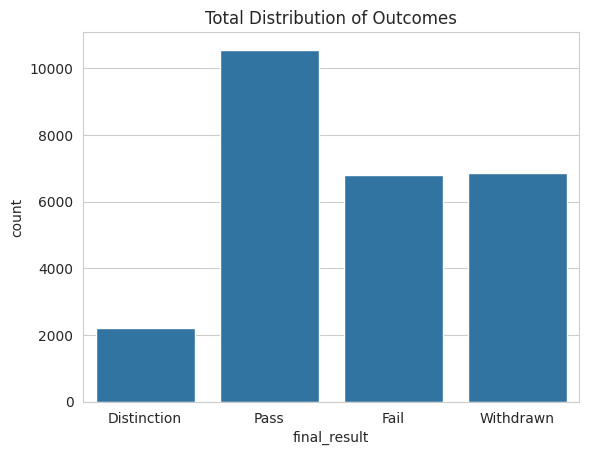

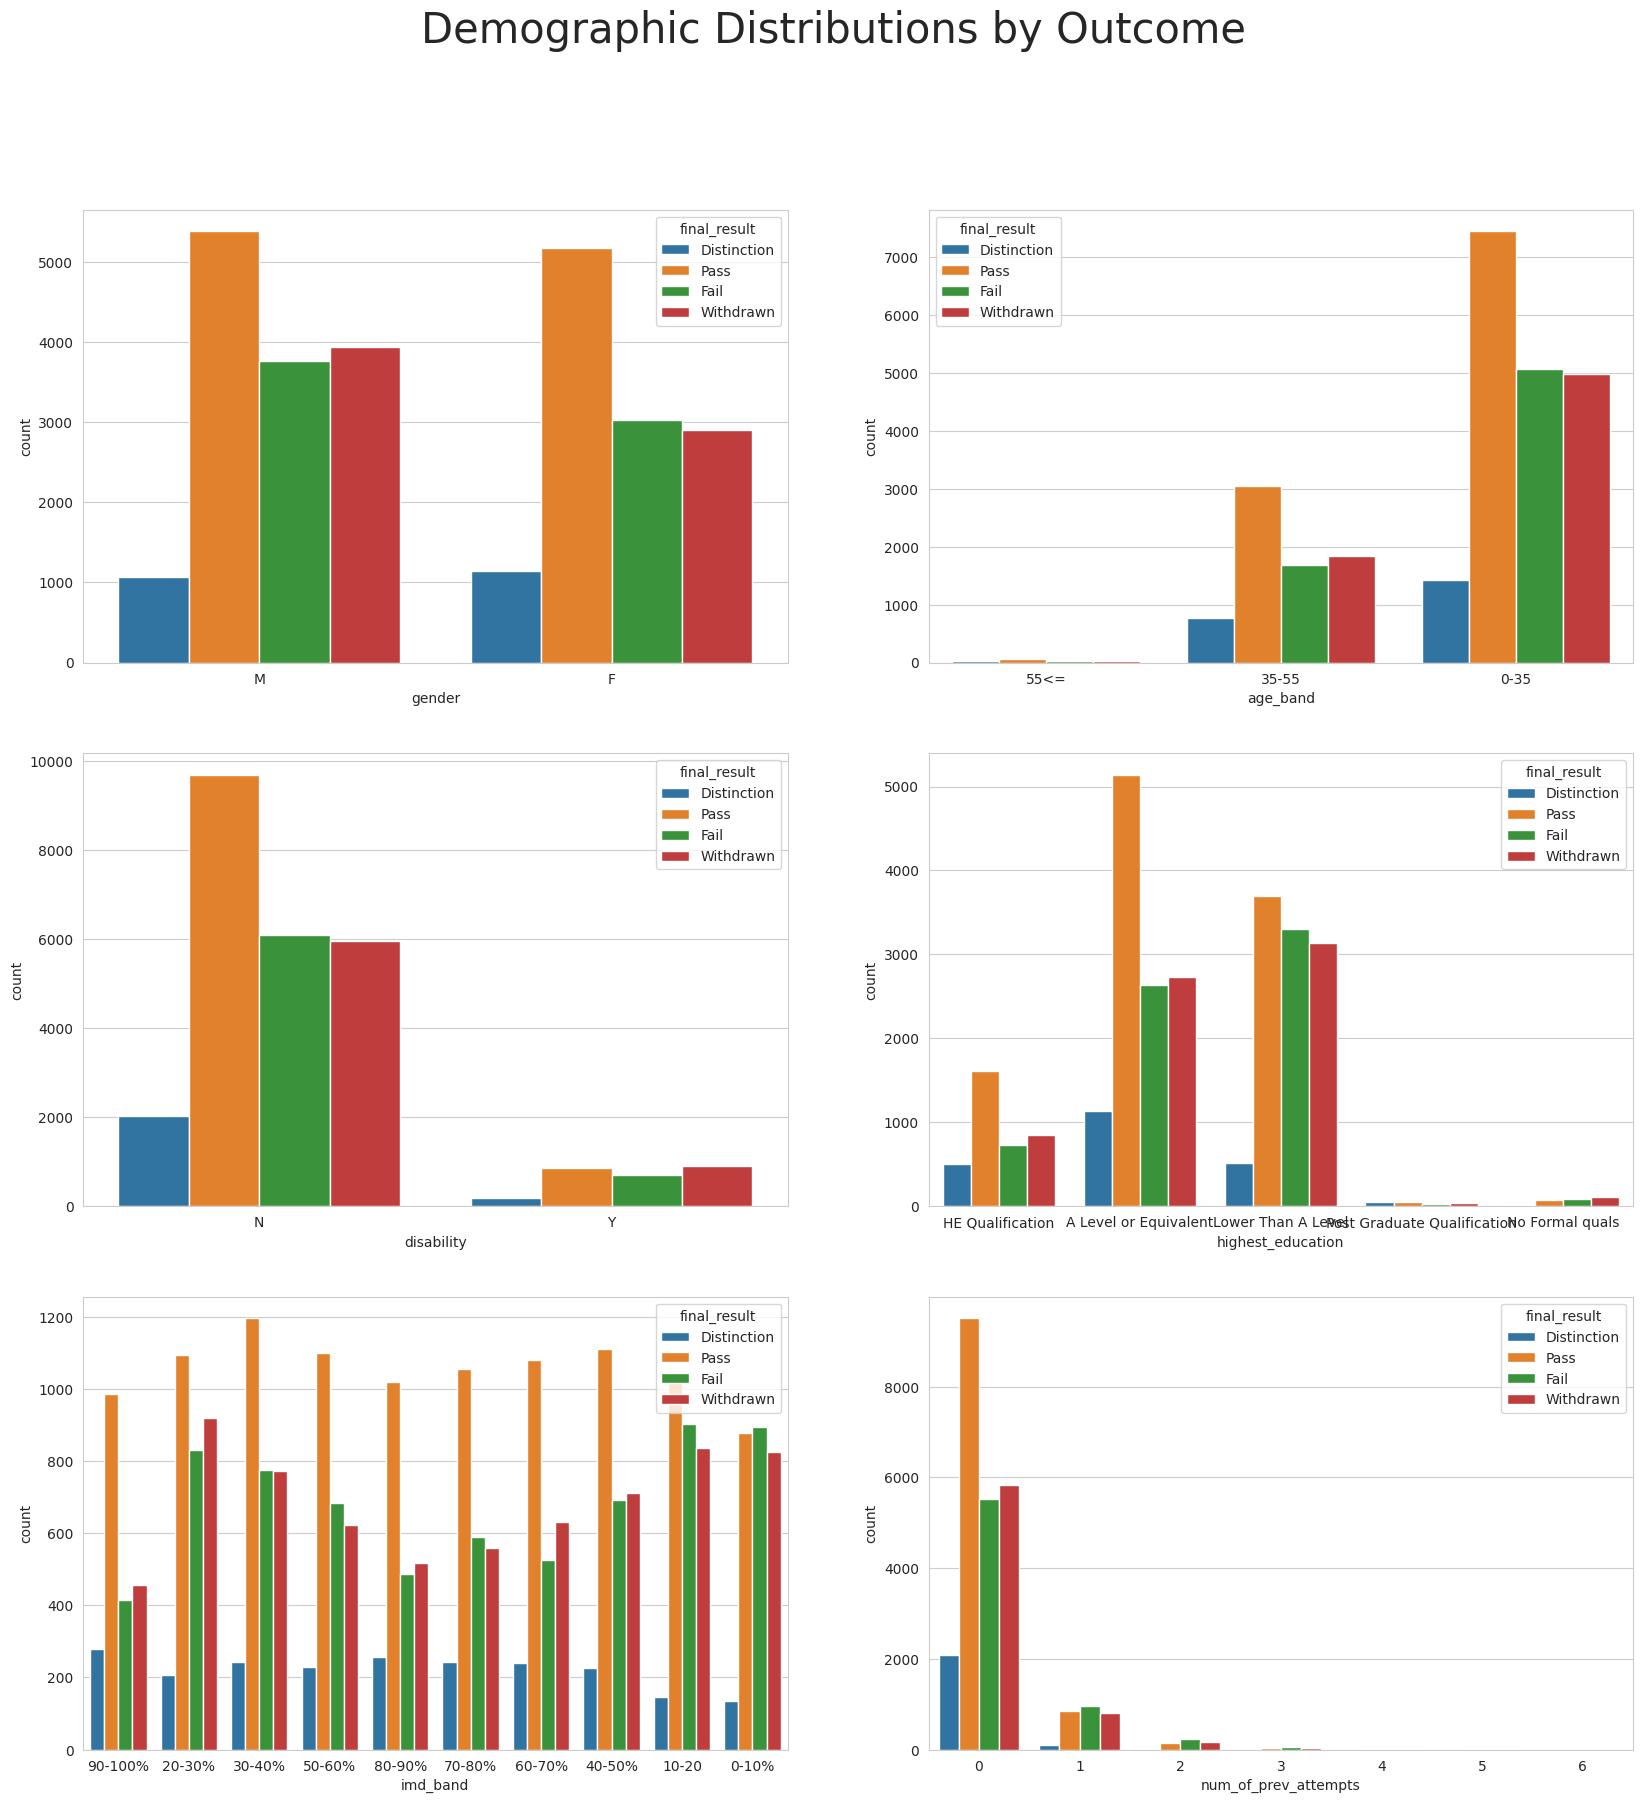

In [25]:
hue_order = ['Distinction','Pass','Fail','Withdrawn']
sns.countplot(data=regs, x='final_result',
              order = hue_order).set_title('Total Distribution of Outcomes')

demos = ['gender','age_band','disability','highest_education','imd_band','num_of_prev_attempts']

fig, axes = plt.subplots(3,2,figsize = (20,20))
axes = axes.ravel()

for i, col in enumerate(demos):
    sns.countplot(data=regs, x=col, hue='final_result',
                  hue_order = hue_order, ax=axes[i])

fig.suptitle('Demographic Distributions by Outcome', fontsize = 30)
plt.show()


# **Distribution of Registrations**

Text(0.5, 1.0, 'Distribution of Registrations')

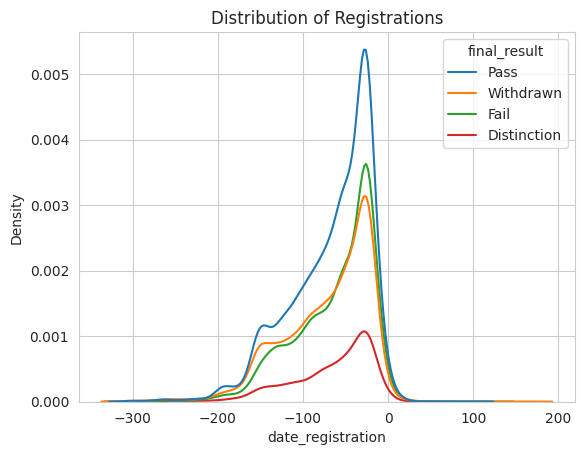

In [26]:
sns.kdeplot(data=regs,
            x='date_registration',
            hue = 'final_result').set_title('Distribution of Registrations')

# **Cumulative Withdrawals by Date**

Text(0.5, 1.0, 'Distribution of Withdrawal Dates')

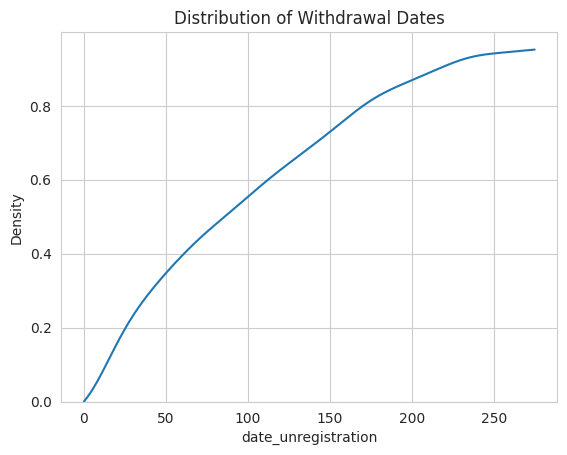

In [27]:
sns.kdeplot(data=regs[regs.final_result == 'Withdrawn'], x='date_unregistration',
            clip = (0,275), cumulative = True).set_title('Distribution of Withdrawal Dates')


# **Total Clicks Distribution by Course**

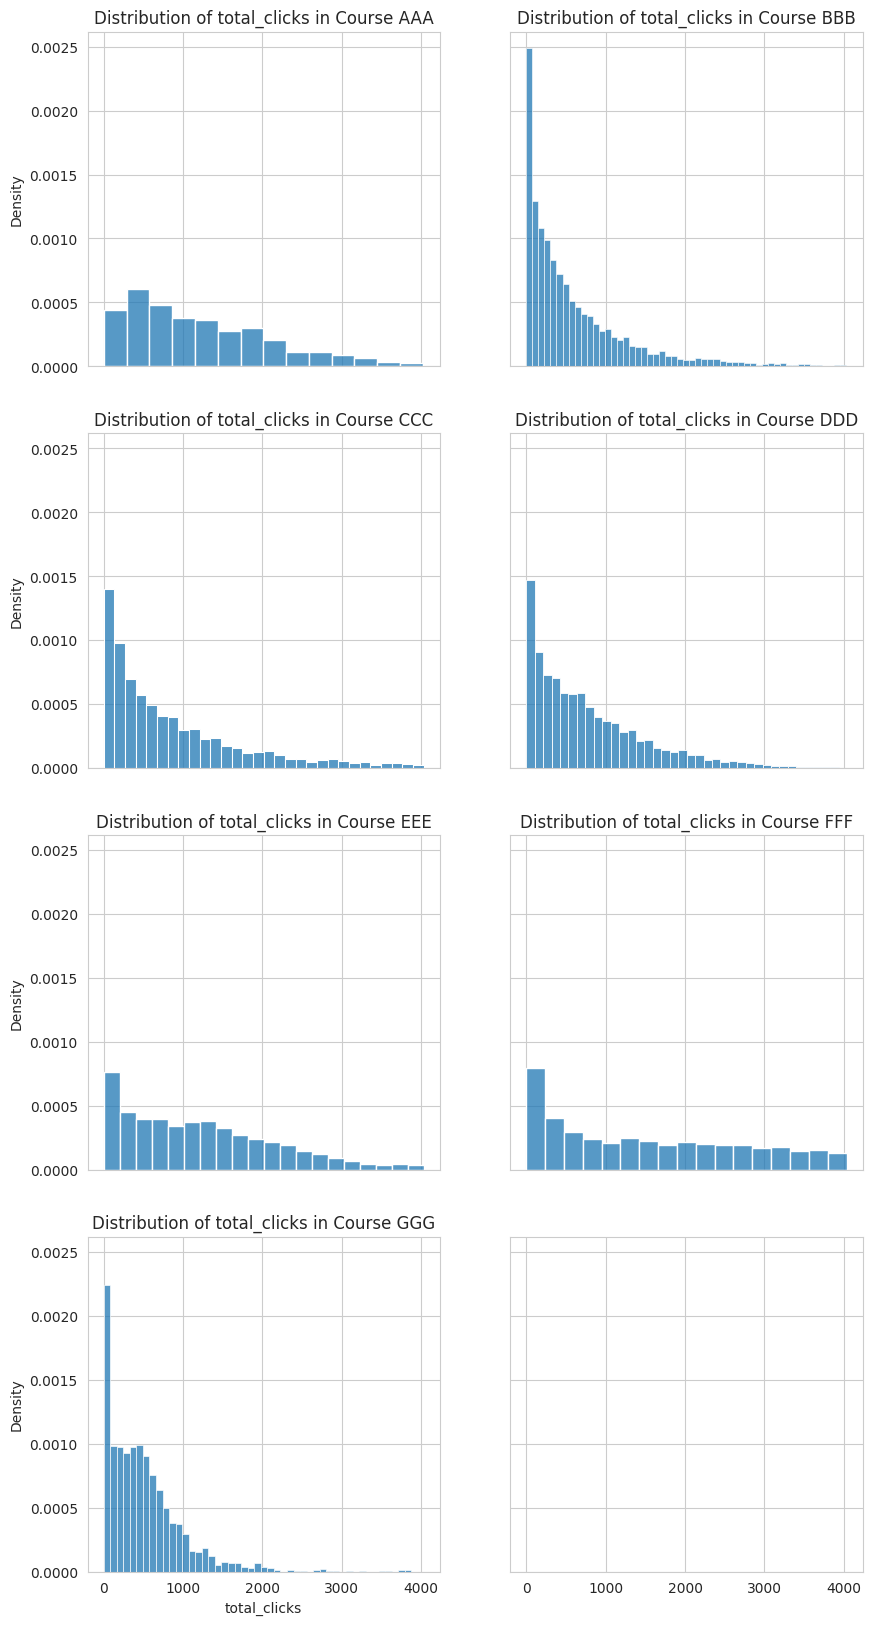

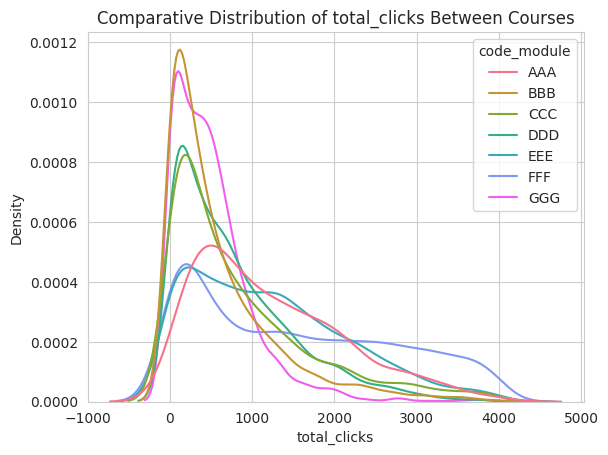

In [28]:
dist_by_course(my_data,column='total_clicks')

# **Are Assessments Harder in Some Courses?**

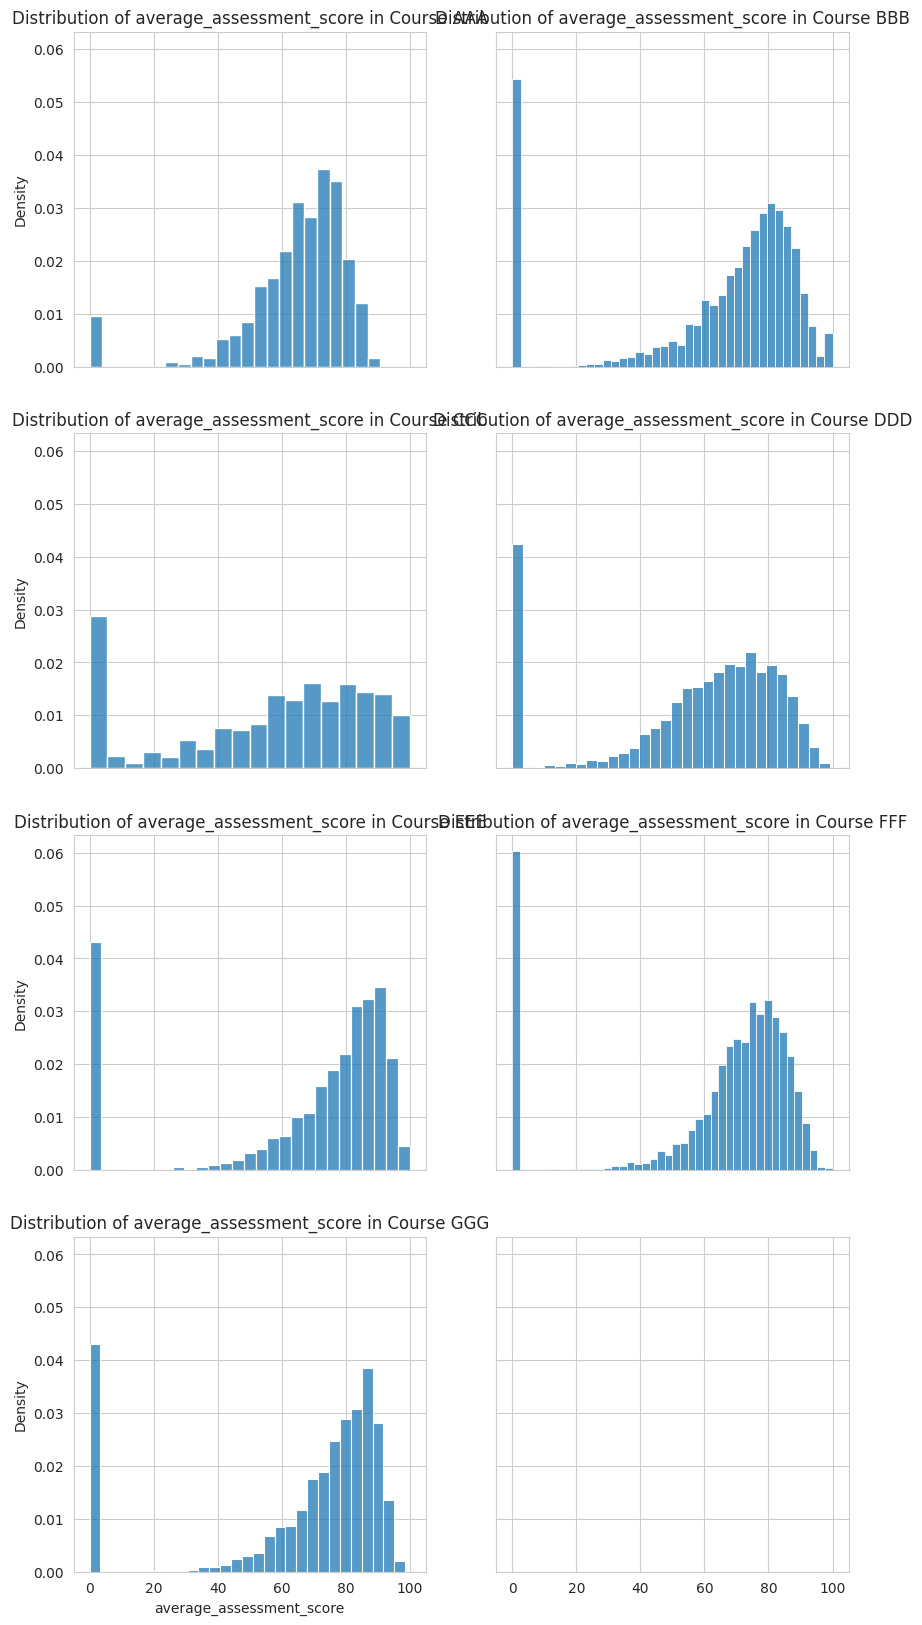

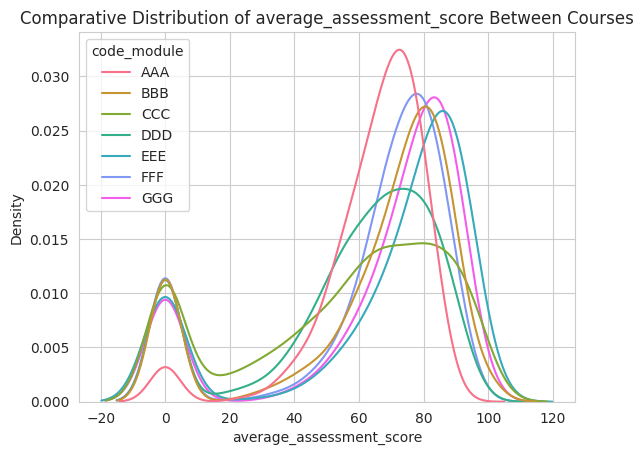

In [29]:
dist_by_course(my_data,'average_assessment_score')

# **Do Courses Have the Same Number of Activities?**

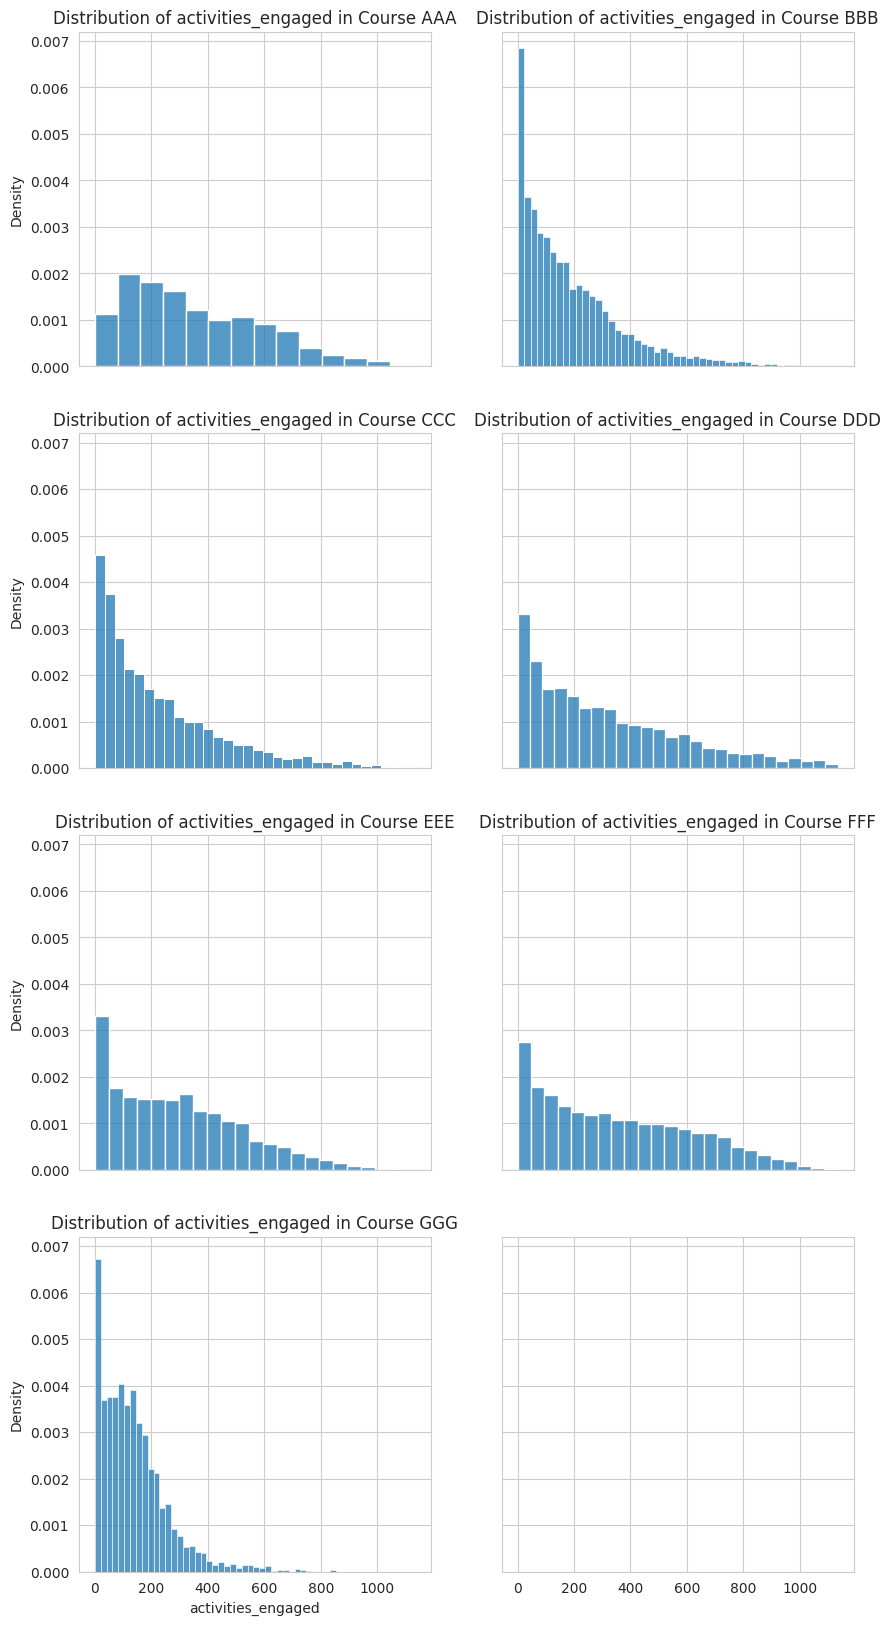

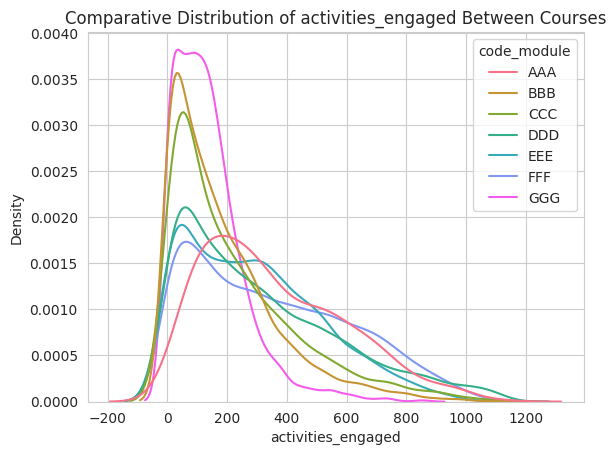

In [30]:
dist_by_course(my_data,'activities_engaged')


# **Do students study the same number of days for each course?**

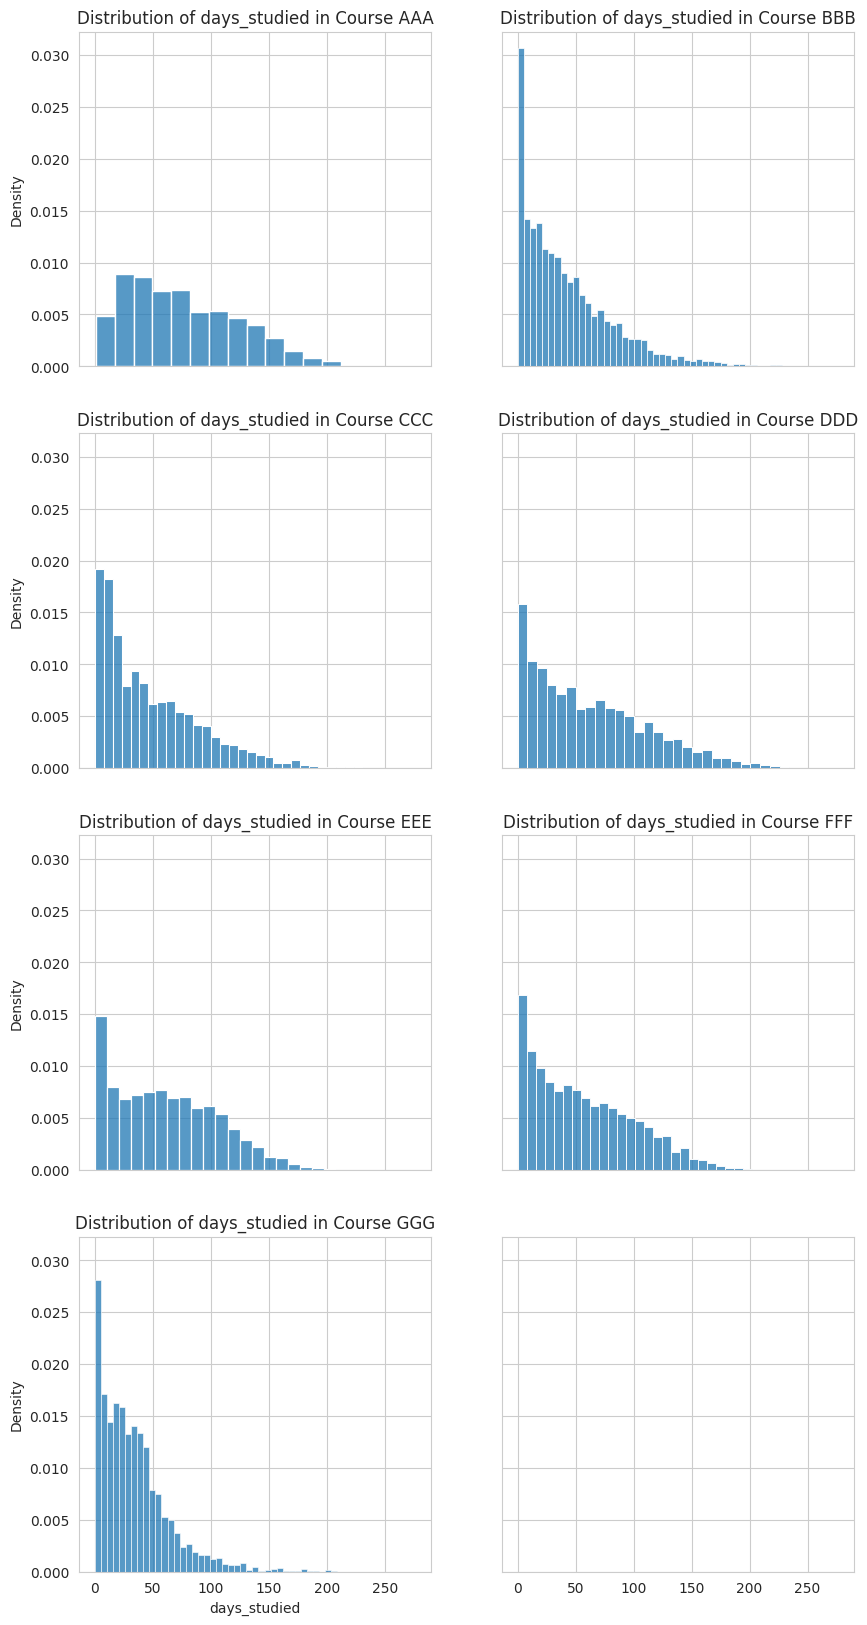

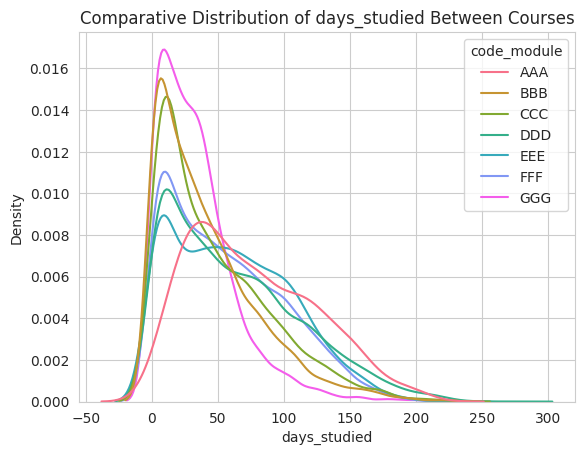

In [31]:
dist_by_course(my_data,'days_studied')


Text(0.5, 1.0, 'Completion Rates by Course')

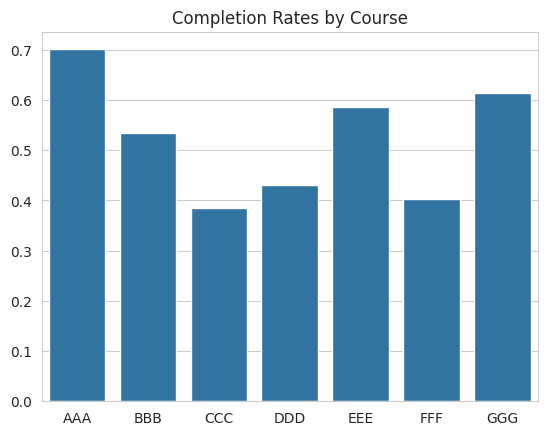

In [32]:
course_completions = []
courses = my_data['code_module'].unique()
for course in courses:
    course_df = my_data[my_data['code_module'] == course]
    completion_rate = len(course_df[course_df['final_result'].isin(['Distinction','Pass'])])
    completion_rate = completion_rate / len(course_df)
    course_completions.append(completion_rate)
sns.barplot(y=course_completions, x=courses)
plt.title('Completion Rates by Course')


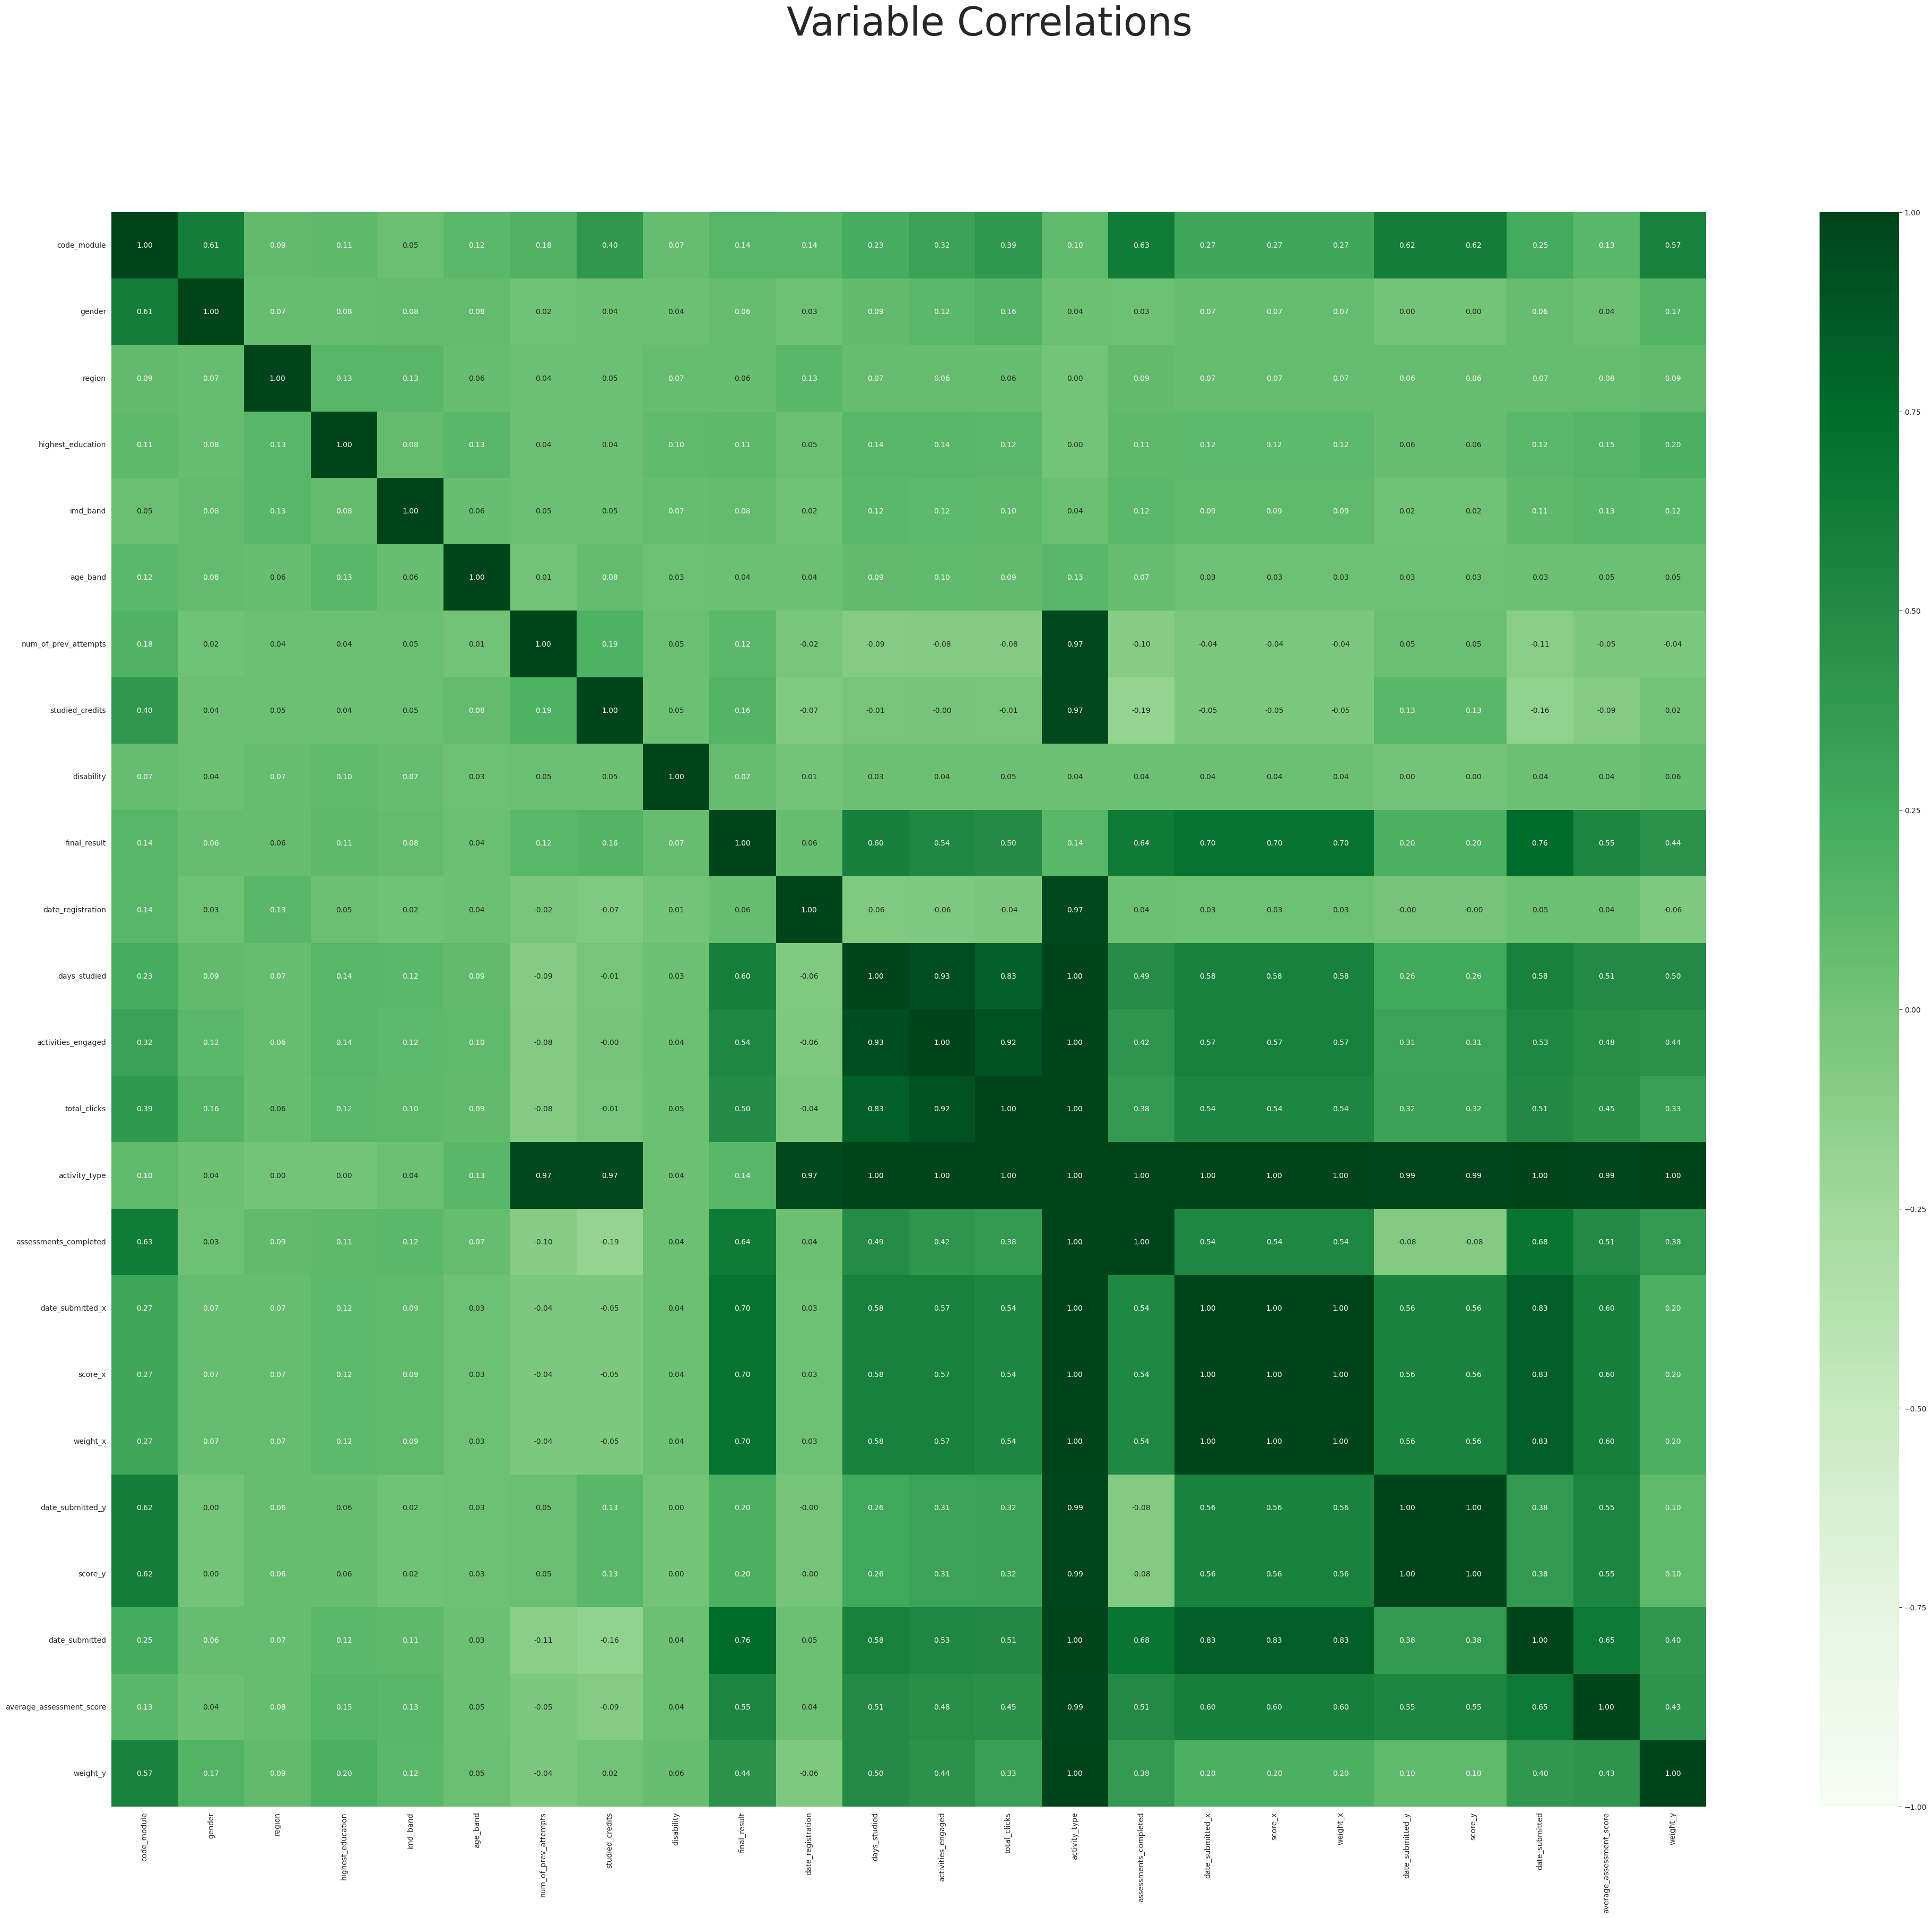

In [33]:
registration_correlations(prediction_window=None, cmap = 'Greens')

Text(0.5, 1.0, 'Courses by Gender Count')

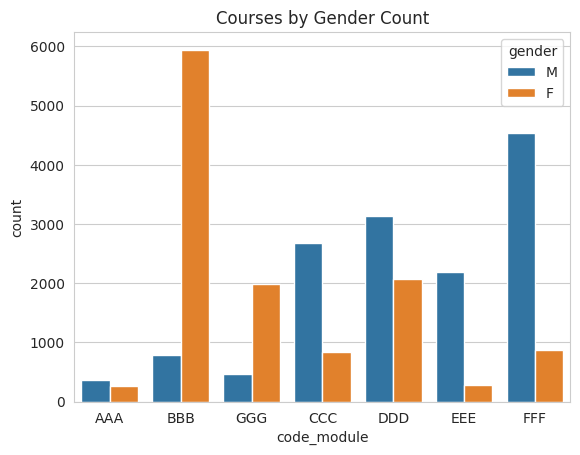

In [34]:
sns.countplot(data=regs, x='code_module', order = ['AAA','BBB','GGG','CCC','DDD','EEE','FFF'],
                                                   hue='gender').set_title('Courses by Gender Count')

Text(0.5, 1.0, 'Average Number of Previous Attempts per Outcome')

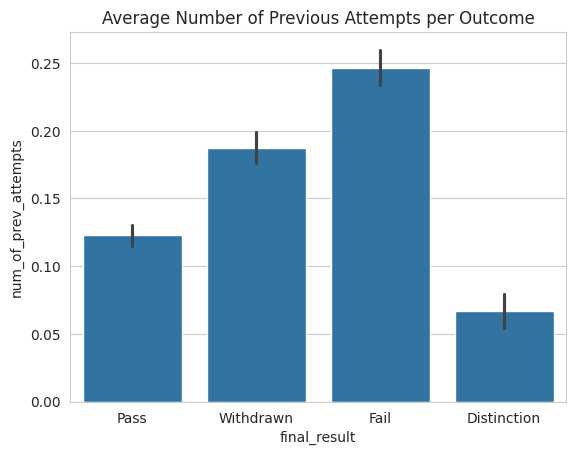

In [35]:
sns.barplot(x=regs['final_result'], y=regs['num_of_prev_attempts'])
plt.title('Average Number of Previous Attempts per Outcome')

Text(0.5, 1.0, 'Total Clicks by Age Group')

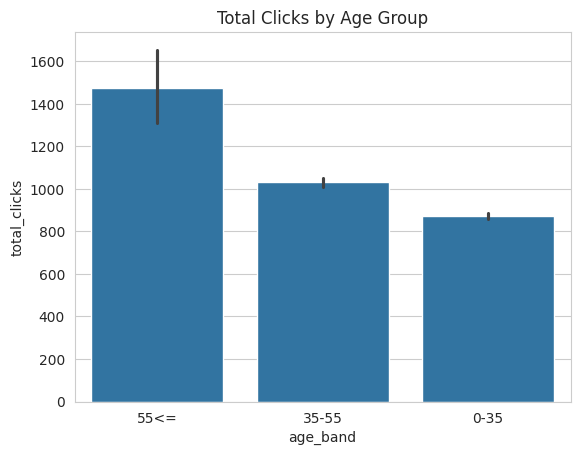

In [36]:
sns.barplot(x=regs['age_band'], y=regs['total_clicks'])
plt.title('Total Clicks by Age Group')


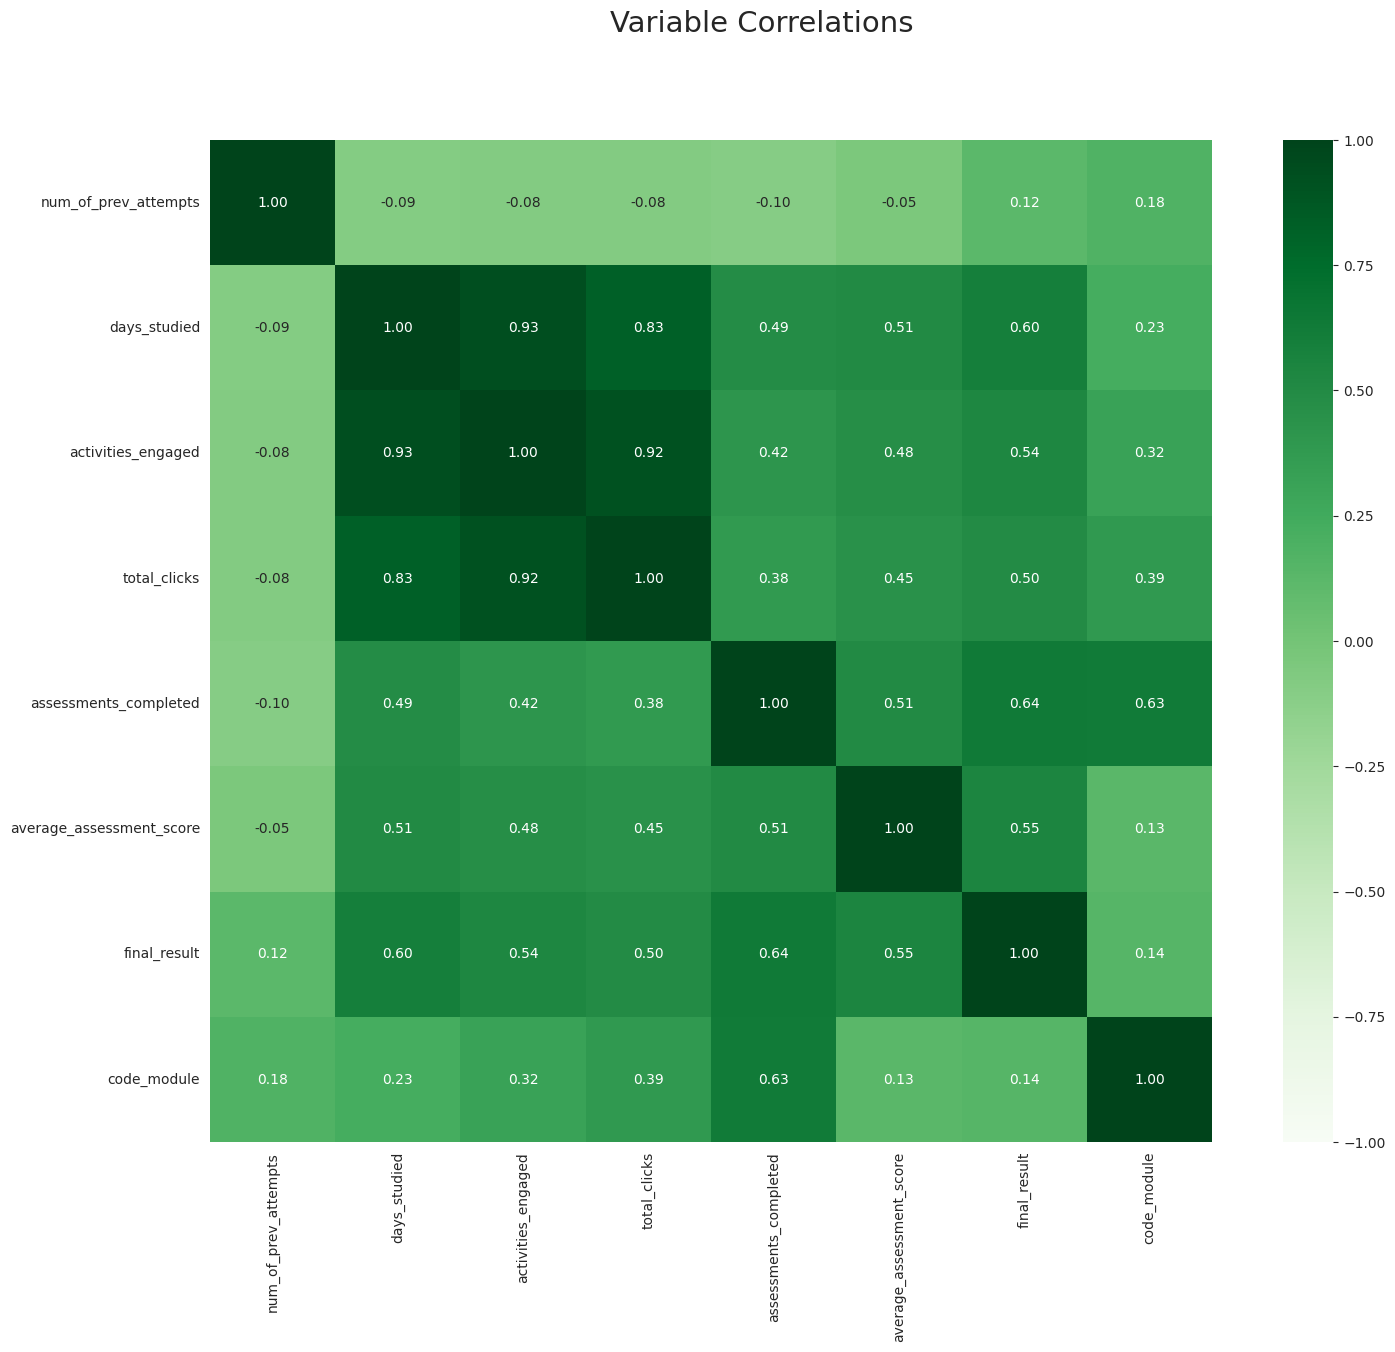

In [37]:
registration_correlations(columns = ['num_of_prev_attempts','days_studied','activities_engaged',
                                     'total_clicks','assessments_completed',
                                     'average_assessment_score','final_result', 'code_module'],
                         cmap = 'Greens')

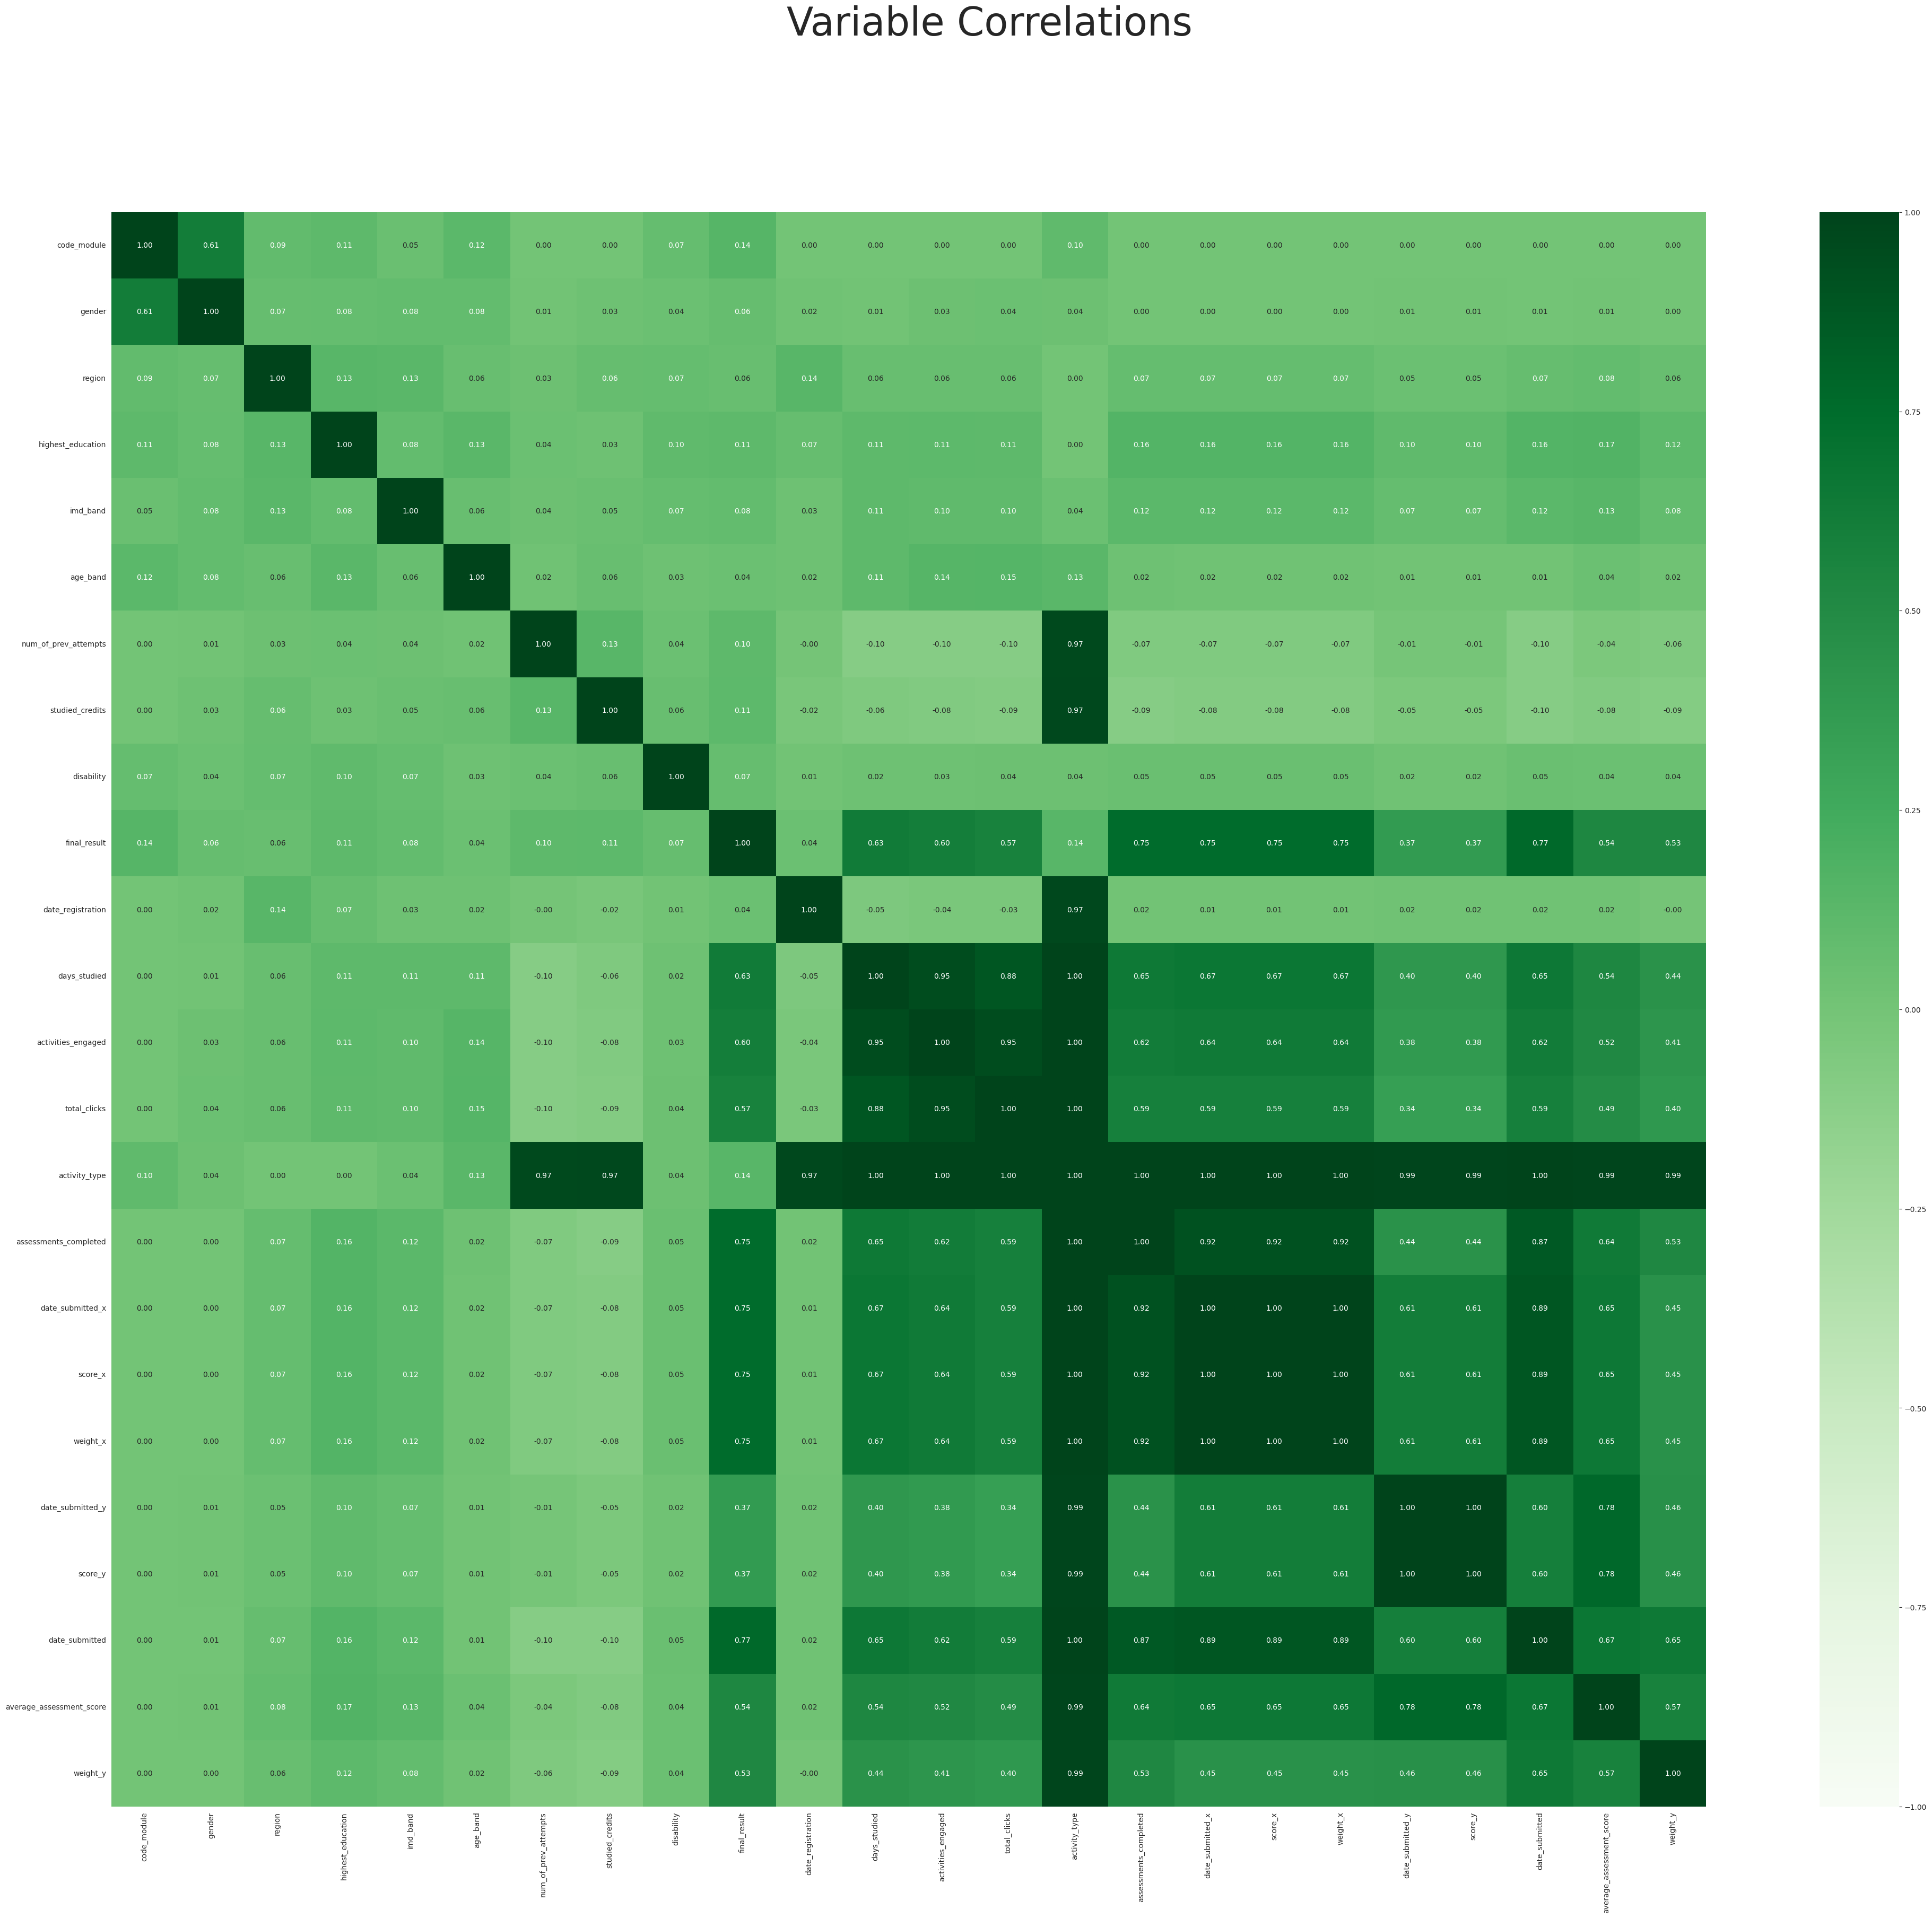

In [38]:
registration_correlations(cmap = 'Greens', scaled = True)

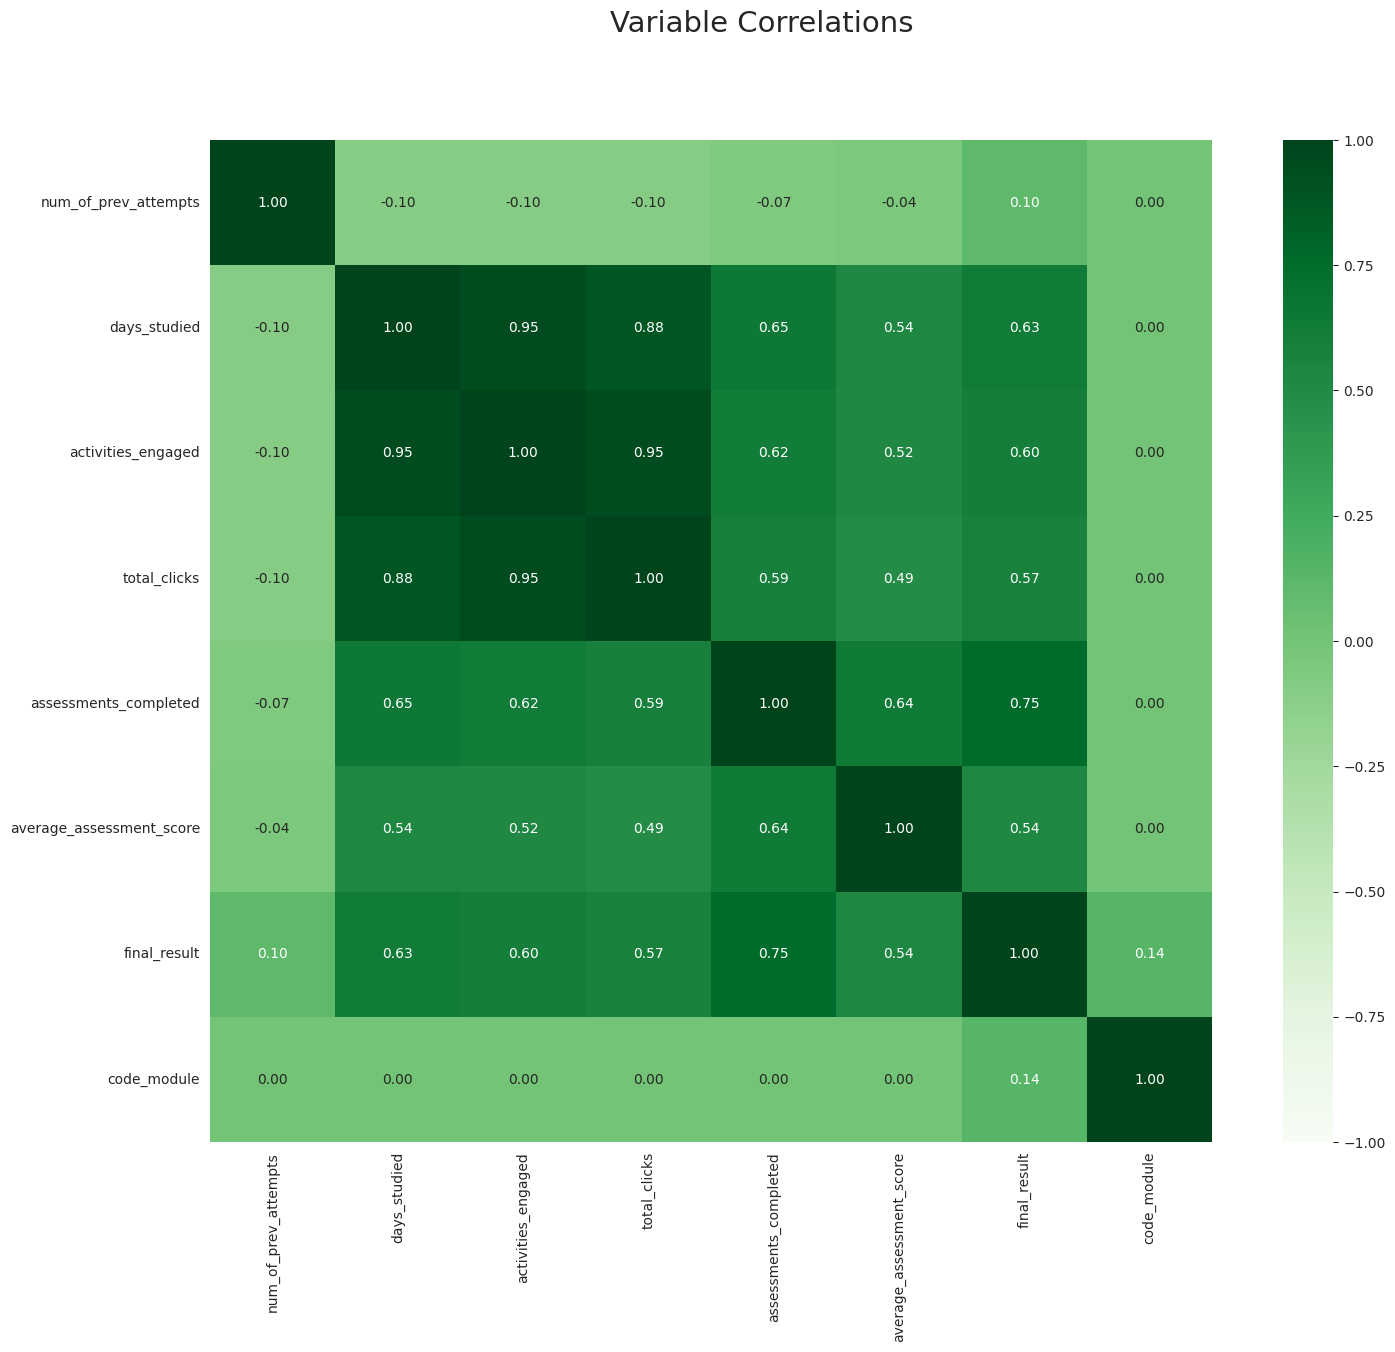

In [39]:
registration_correlations(columns = ['num_of_prev_attempts',
                                     'days_studied','activities_engaged',
                                     'total_clicks','assessments_completed',
                                     'average_assessment_score','final_result', 'code_module'],
                           cmap = 'Greens', scaled=True)

Text(0.5, 1.0, 'Scaled Distribution of average_assessment_score Between Courses')

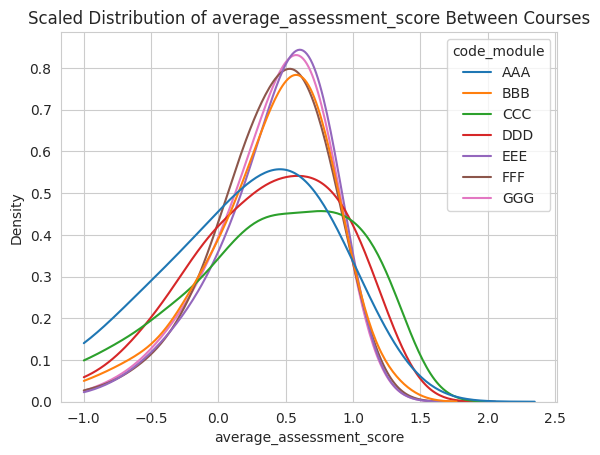

In [40]:
data = load_OU_data()

scaled_regs = CourseScaler(drop_course=False).fit_transform(data[['code_module','num_of_prev_attempts',
                                     'days_studied','activities_engaged',
                                     'total_clicks','assessments_completed',
                                     'average_assessment_score']], )

sns.kdeplot(data = scaled_regs, x = 'average_assessment_score', hue = 'code_module', clip=(-1,5,2),
            common_norm = False)

plt.title('Scaled Distribution of average_assessment_score Between Courses')

In [41]:
data = load_OU_data(prediction_window = .5)
data.drop(columns = ['id_student','region','highest_education',\
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration', 'num_of_prev_attempts'], inplace = True)
if 'date_unregistration' in data.columns:
    data.drop(columns = ['date_unregistration'], inplace = True)
data.head()

code_module code_presentation final_result  days_studied  \
0         AAA             2013J         Pass          26.0   
1         AAA             2013J         Pass          45.0   
2         AAA             2013J         Pass          68.0   
3         AAA             2013J         Pass          40.0   
4         AAA             2013J         Pass          70.0   

   activities_engaged  total_clicks  \
0               119.0         625.0   
1               256.0         880.0   
2               341.0        1160.0   
3               197.0         733.0   
4               355.0        1251.0   

                                       activity_type  assessments_completed  \
0  oucontentoucontentforumngoucontentoucontentouc...               0.003145   
1  forumngforumnghomepageoucontentforumngsubpageo...               0.002096   
2  oucontentresourcesubpagehomepageglossaryoucont...               0.003145   
3  oucontentresourceforumnghomepageforumngouconte...               0.002096   
4  subpageresourceforumngoucontenthomepageouconte...               0.003145   

   date_submitted_x  score_x  weight_x  date_submitted_y  score_y  \
0               3.0      3.0       3.0             954.0    954.0   
1               2.0      2.0       2.0             954.0    954.0   
2               3.0      3.0       3.0             954.0    954.0   
3               2.0      2.0       2.0             954.0    954.0   
4               3.0      3.0       3.0             954.0    954.0   

   date_submitted  average_assessment_score   weight_y  
0       62.000000                 81.000000  16.666667  
1       37.000000                 69.000000  15.000000  
2       61.000000                 72.333333  16.666667  
3       50.500000                 49.500000  15.000000  
4       66.666667                 74.000000  16.666667

In [42]:
data.describe()

days_studied  activities_engaged  total_clicks  assessments_completed  \
count  23454.000000        23454.000000  23454.000000           23454.000000   
mean      38.545451          209.006140    738.084890               0.000844   
std       27.466590          181.594182    756.687919               0.000586   
min        0.000000            0.000000      0.000000               0.000000   
25%       17.000000           74.000000    207.000000               0.000534   
50%       33.000000          158.000000    486.500000               0.000723   
75%       56.000000          292.000000    997.000000               0.001025   
max      138.000000         1132.000000   4034.000000               0.007737   

       date_submitted_x       score_x      weight_x  date_submitted_y  \
count      23454.000000  23454.000000  23454.000000      23454.000000   
mean           3.344845      3.344845      3.344845       4491.009124   
std            1.832412      1.832412      1.832412       2408.797743   
min            0.000000      0.000000      0.000000          0.000000   
25%            2.000000      2.000000      2.000000       1774.000000   
50%            3.000000      3.000000      3.000000       4834.000000   
75%            5.000000      5.000000      5.000000       5955.000000   
max           12.000000     12.000000     12.000000       7638.000000   

            score_y  date_submitted  average_assessment_score      weight_y  
count  23454.000000    23454.000000              23454.000000  23454.000000  
mean    4491.009124       51.321583                 69.980502      9.813783  
std     2408.797743       19.975529                 23.968856      6.104047  
min        0.000000       -4.000000                  0.000000      0.000000  
25%     1774.000000       46.500000                 64.000000      7.125000  
50%     4834.000000       55.750000                 77.000000     10.000000  
75%     5955.000000       62.333333                 85.364583     13.333333  
max     7638.000000      117.000000                100.000000     28.000000

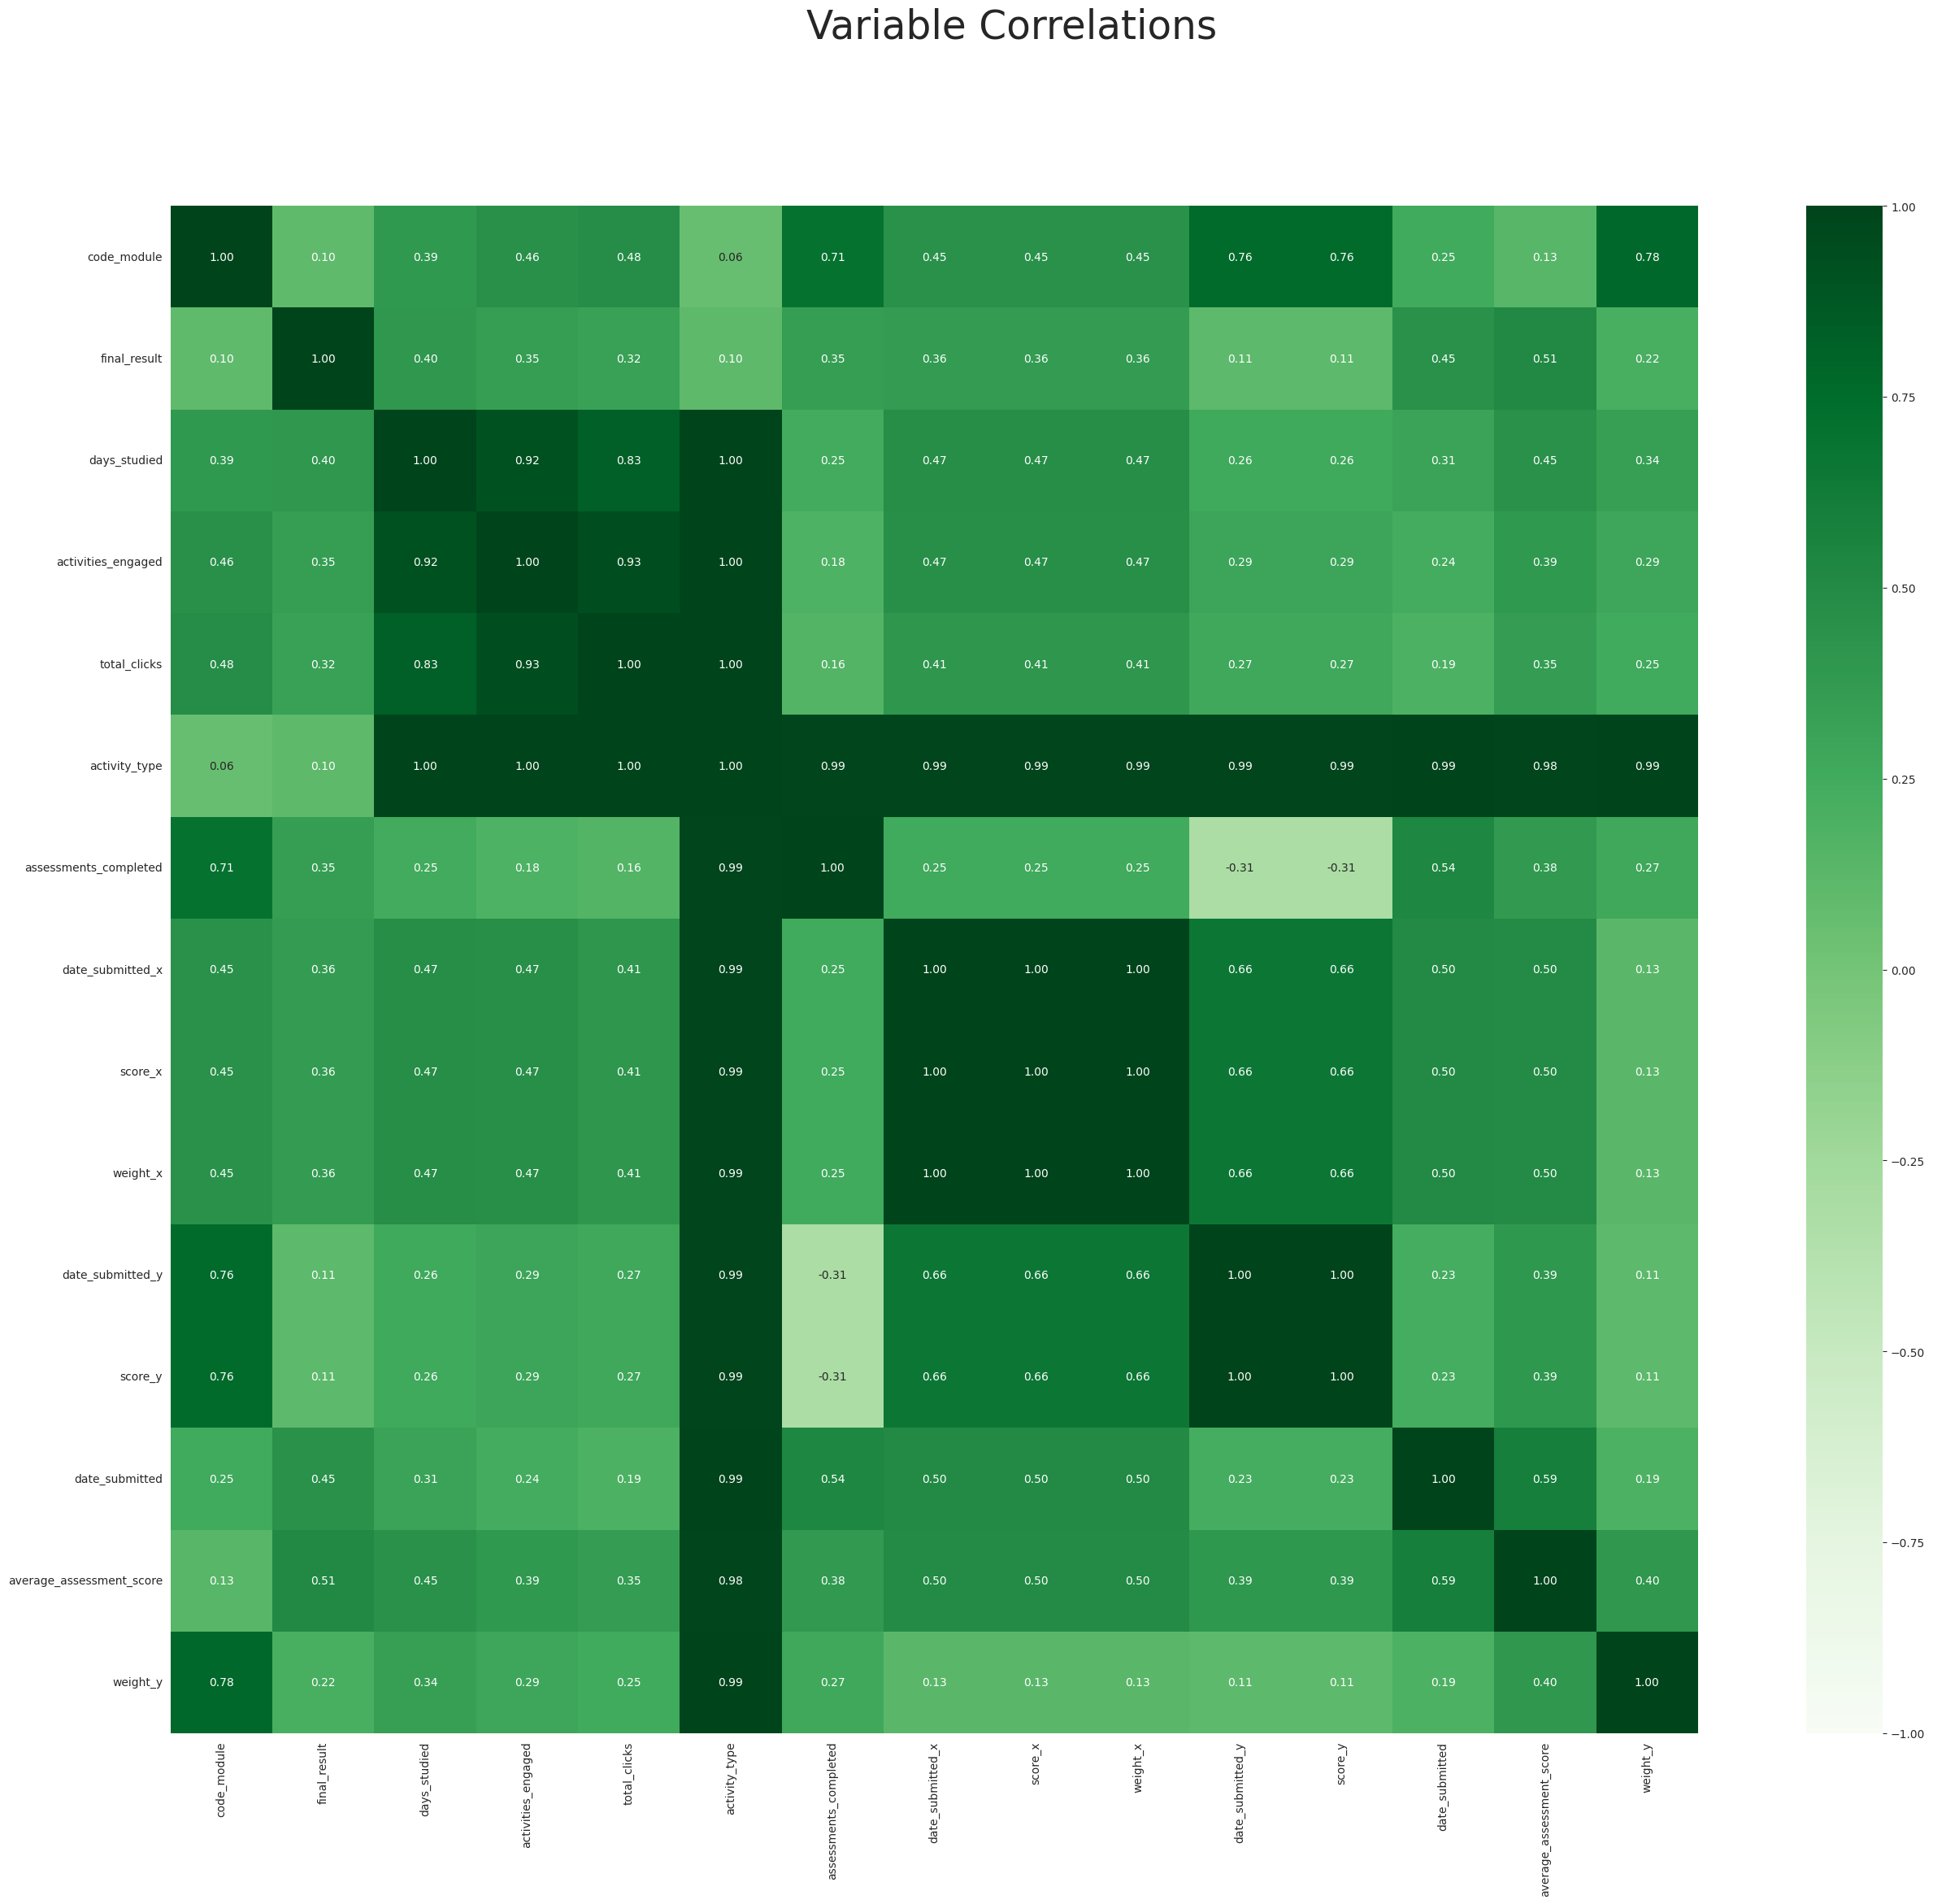

In [43]:
registration_correlations(data, cmap = 'Greens')

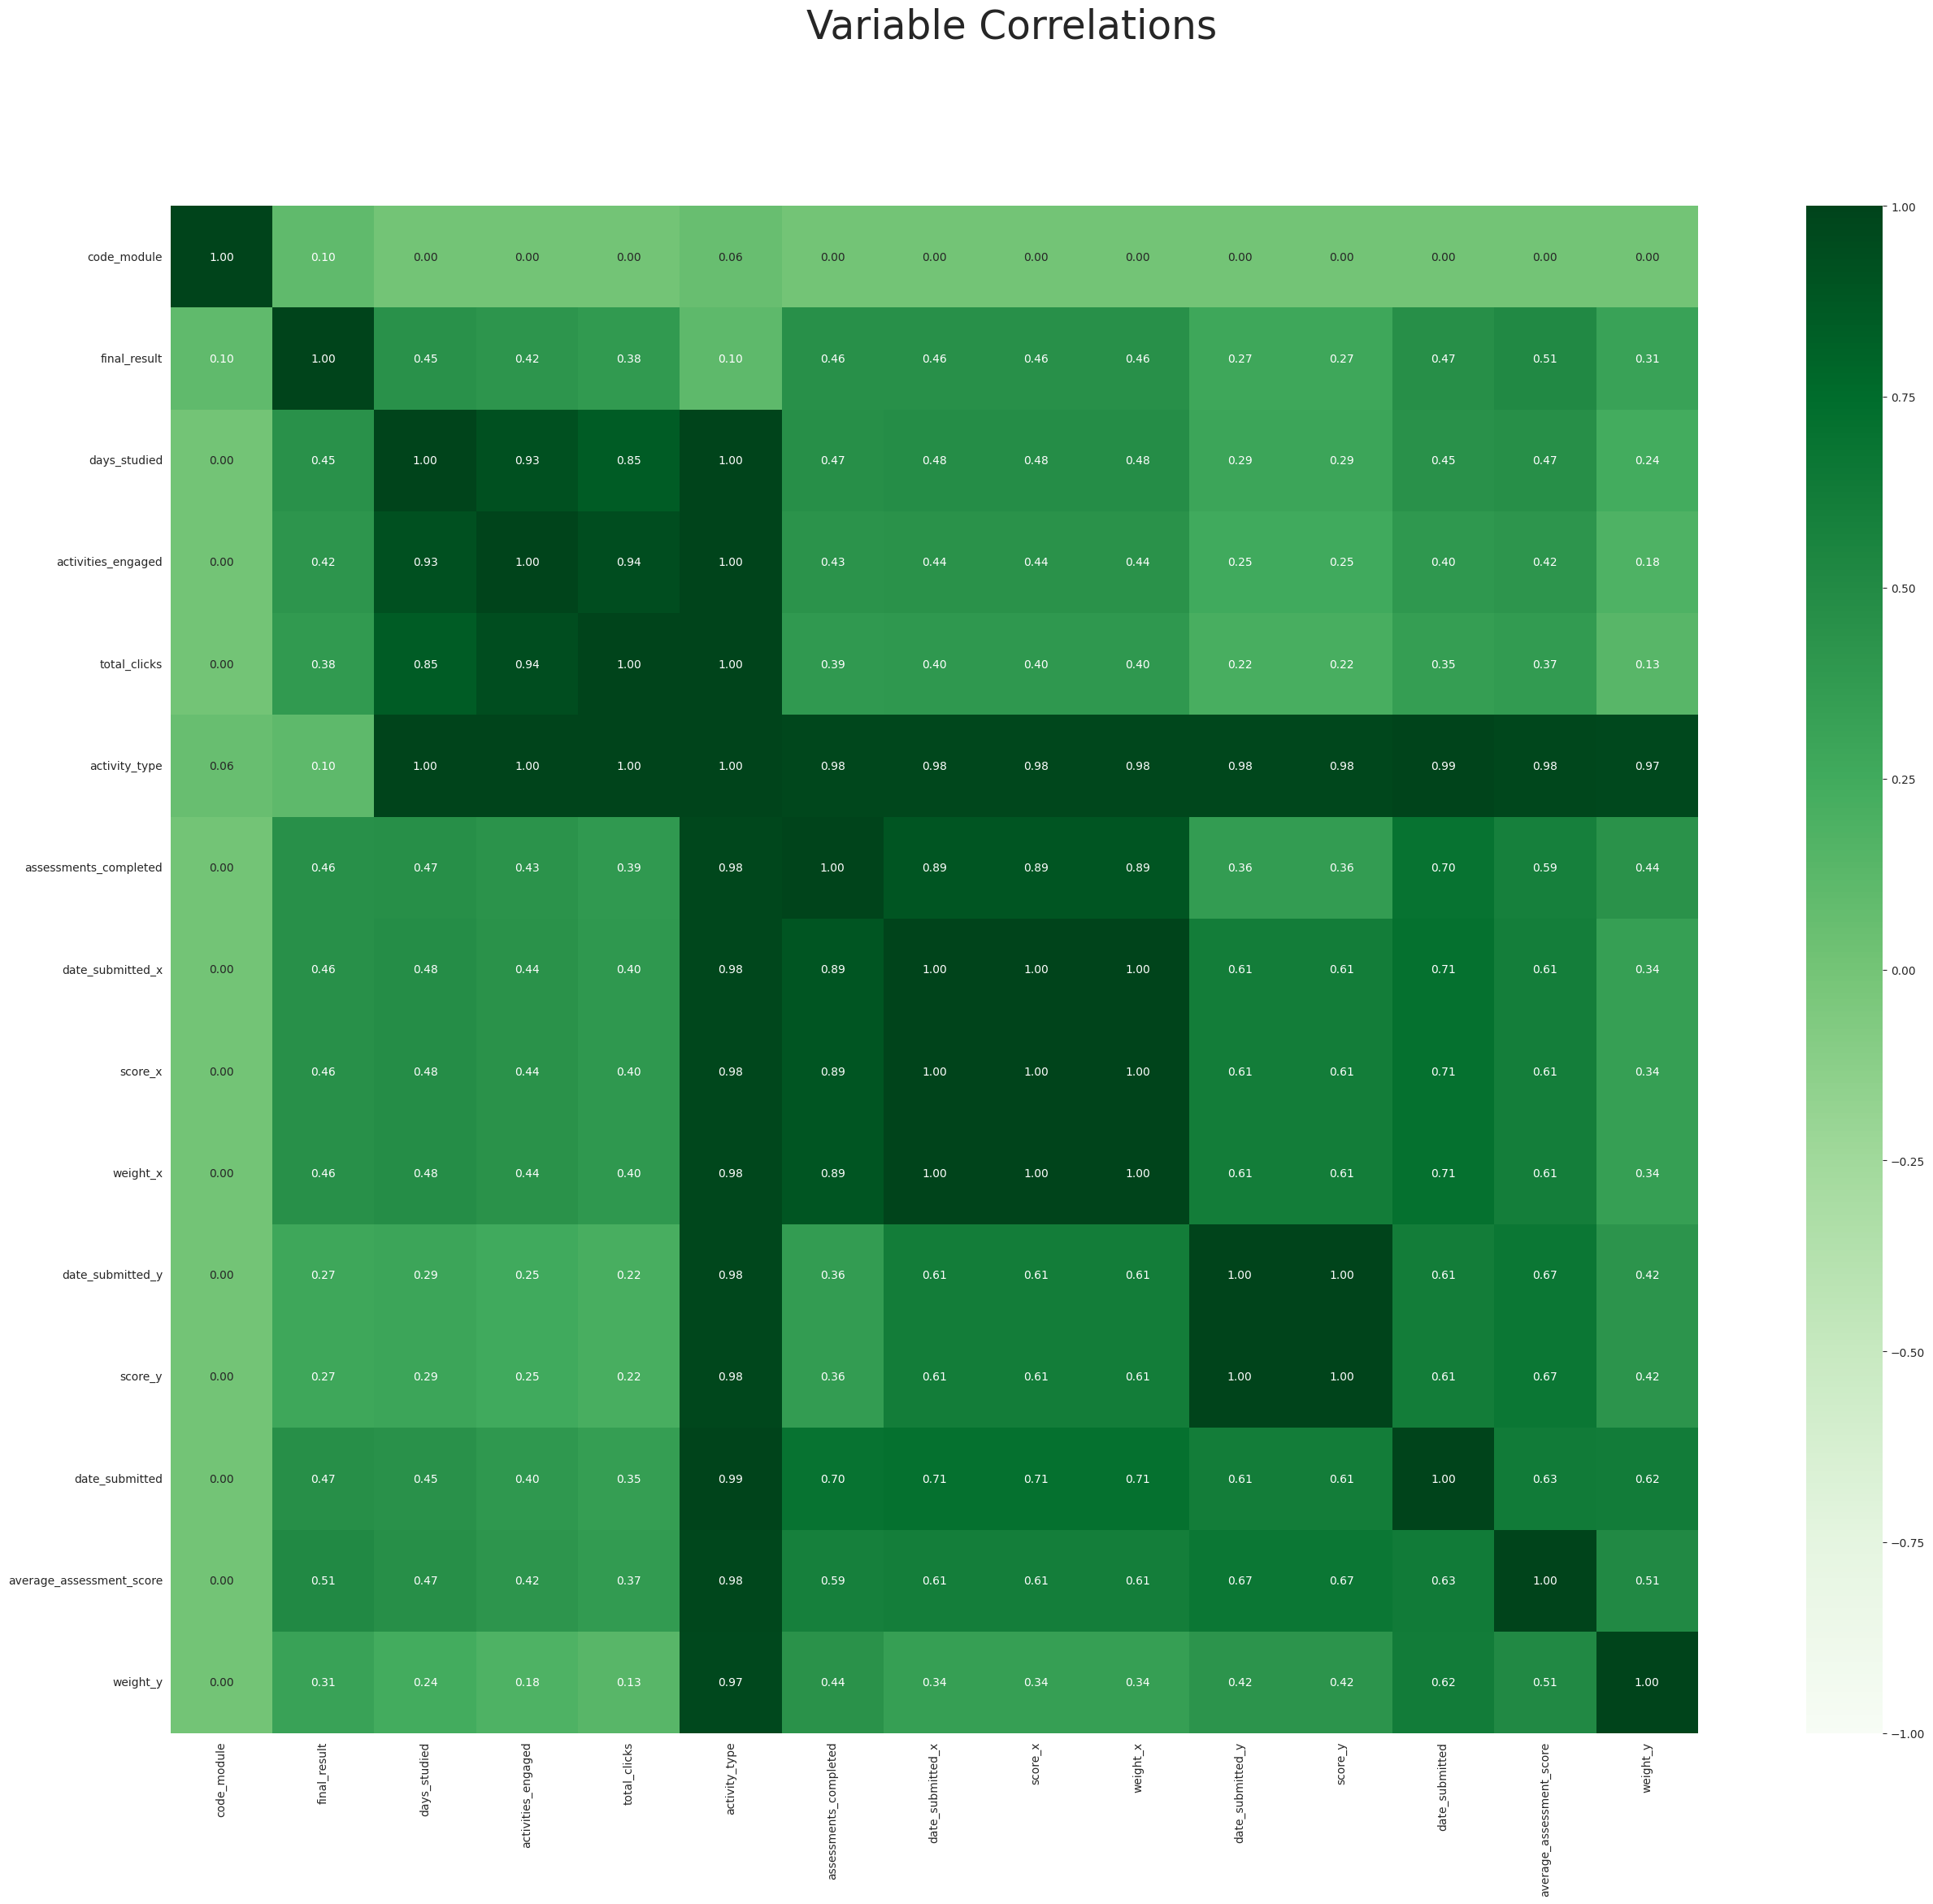

In [44]:
#Setting prediction_window to .5 loads data up to the halfway point of the shortest course present
#Scale the variables, but keep `code_module` for comparing
cs = CourseScaler(drop_course=False)
scaled_data = cs.fit_transform(data)

#create the new correlation matrix
registration_correlations(scaled_data, cmap = 'Greens')

In [45]:
demo_X = load_OU_data(prediction_window = .5)
# Identify non-numeric columns
non_numeric_columns = demo_X.select_dtypes(exclude=['number']).columns

# Convert all entries in the non-numeric columns to strings
for col in non_numeric_columns:
    demo_X[col] = demo_X[col].astype(str)

print("Non-numeric columns converted to strings.")


Non-numeric columns converted to strings.


In [46]:
# Convert non-numeric columns to numeric using LabelEncoder
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    demo_X[col] = le.fit_transform(demo_X[col])
    label_encoders[col] = le

print("Non-numeric columns converted to numeric.")


Non-numeric columns converted to numeric.


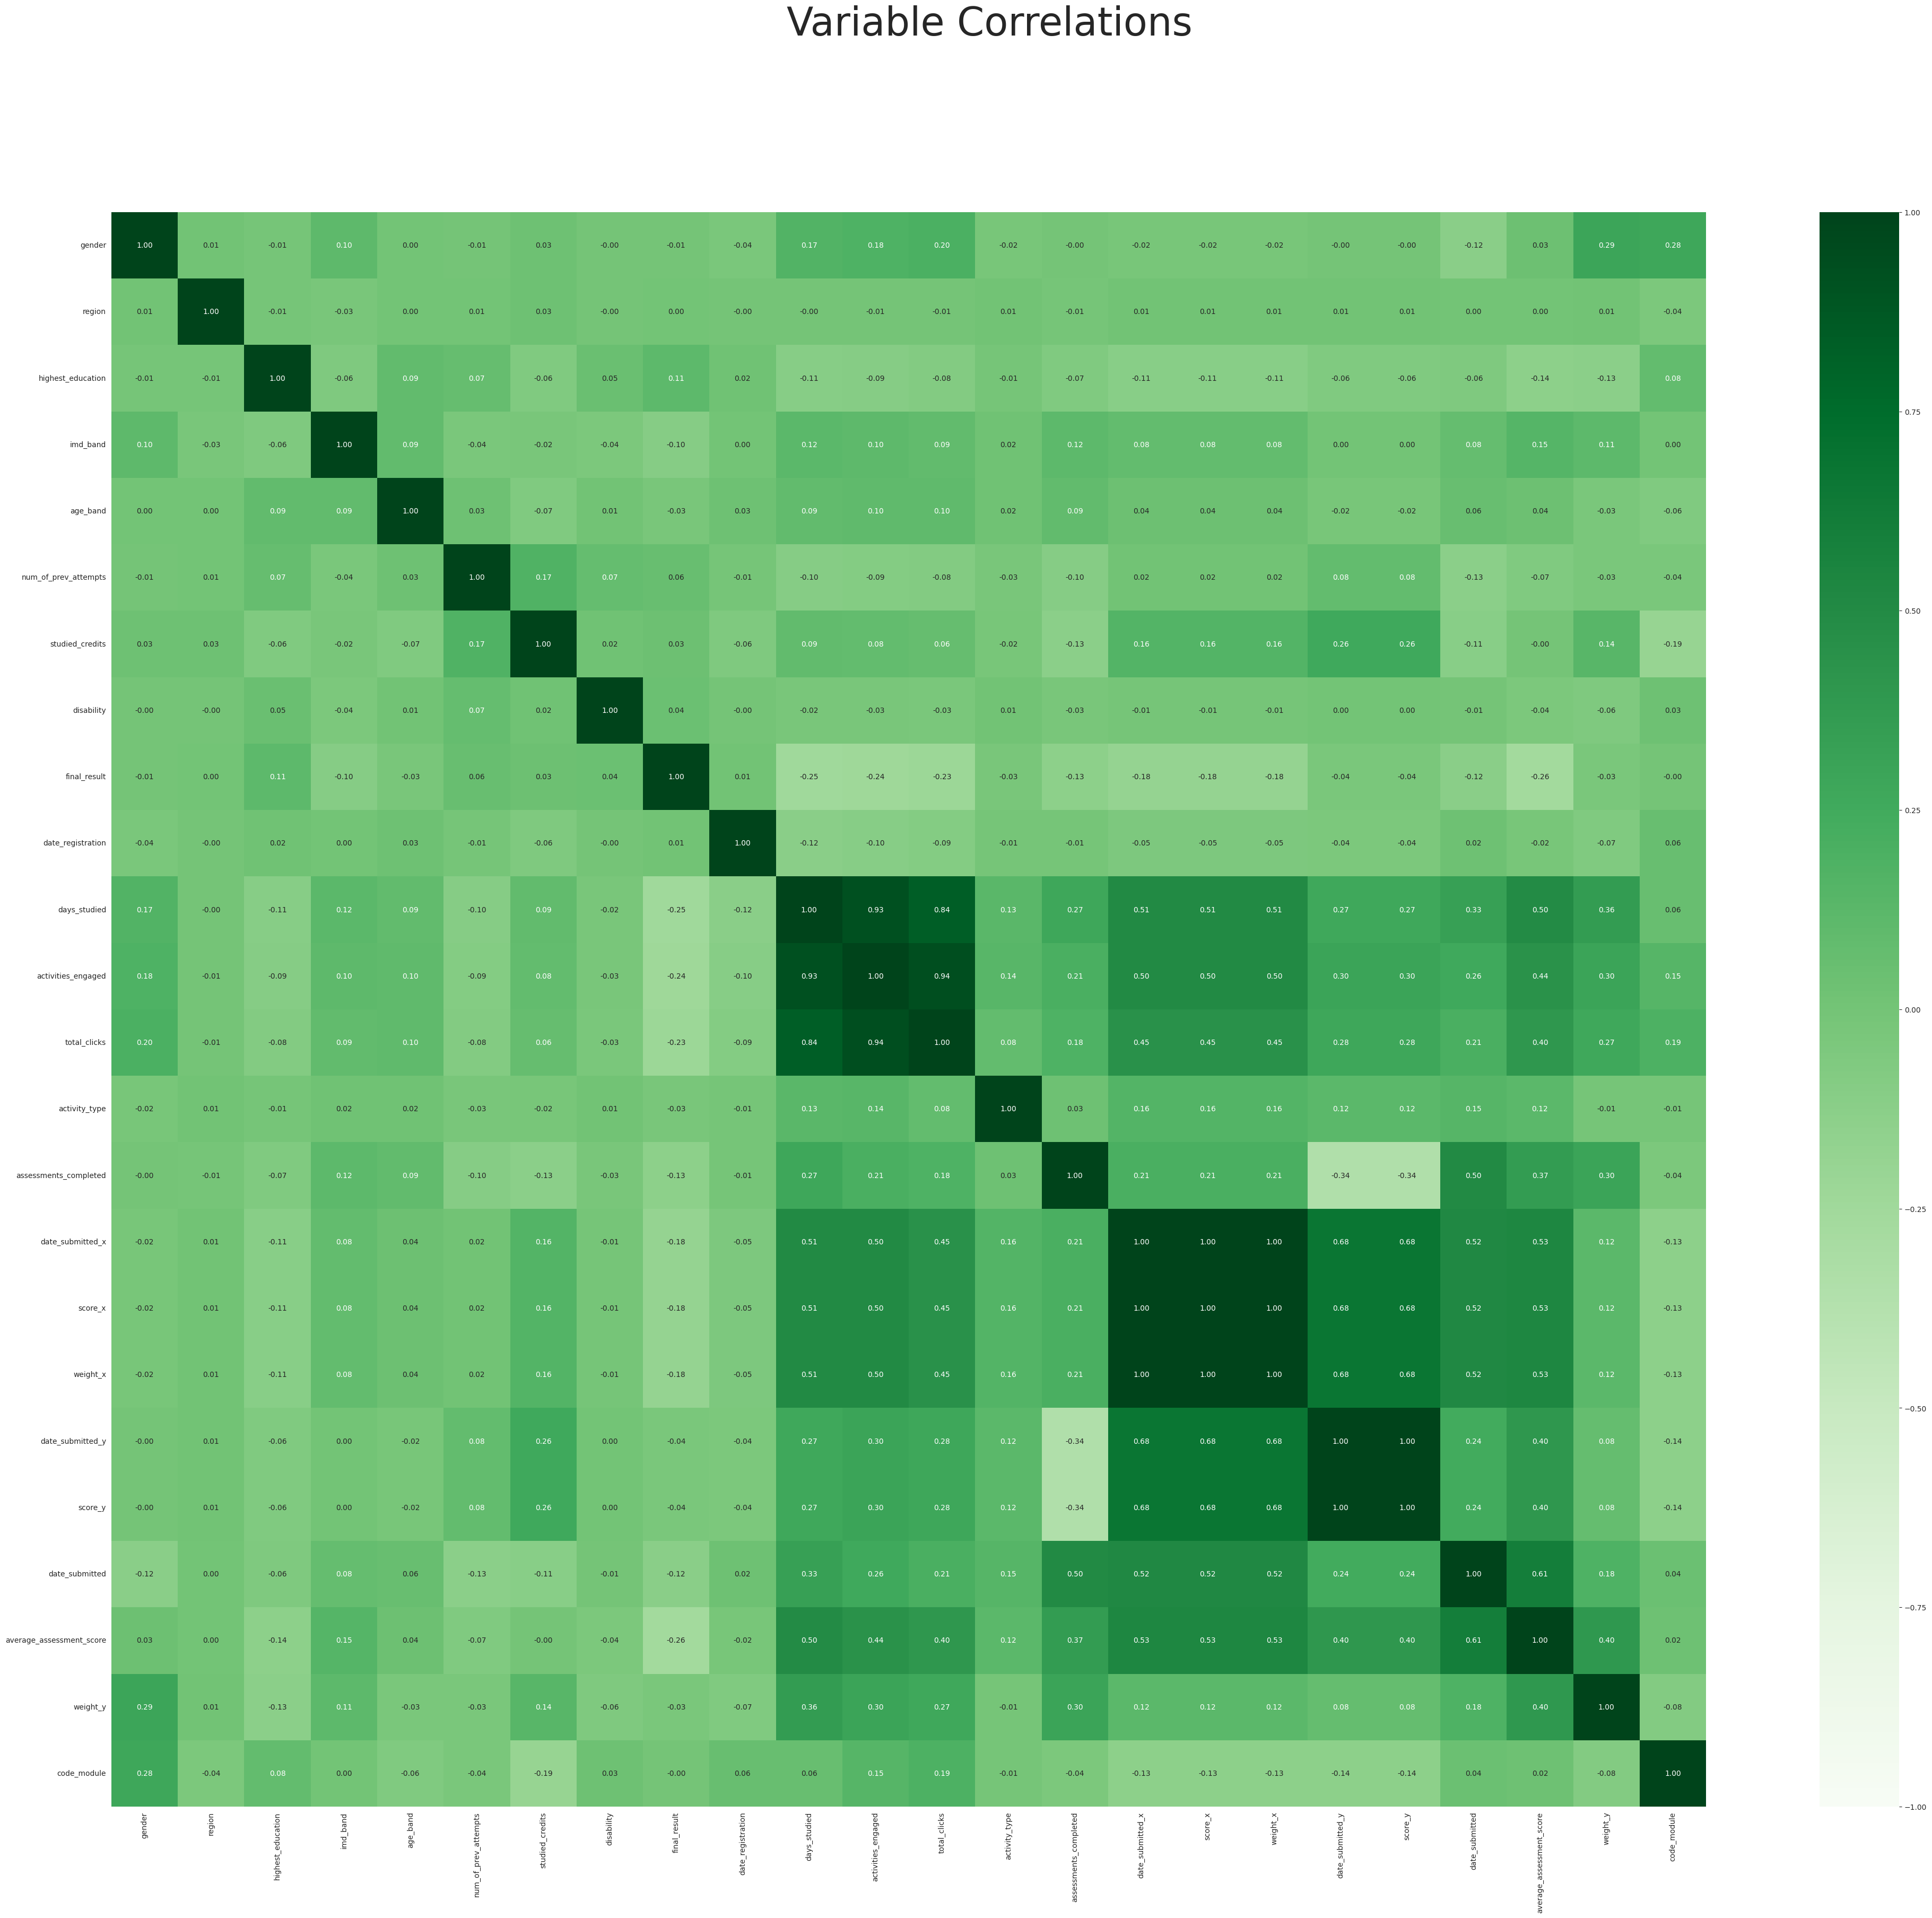

In [47]:
demo_y = demo_X['final_result']
# Apply SMOTE
smoted_X, smoted_y = smotecourses(demo_X, demo_y, drop_course=False)
smoted_X['final_result'] = smoted_y

# Check the correlation again
registration_correlations(smoted_X, cmap='Greens')


In [48]:
!pip install scikit-learn imbalanced-learn xgboost dython


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


In [50]:
# Helper functions
def print_evaluation_metrics(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred, pos_label='Needs Intervention'))
    print("ROC AUC Score:", roc_auc_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def run_grid_search_and_evaluate(model, params, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

    # Classification report without the average parameter
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return best_model

In [51]:
# Load and preprocess data
my_data = load_OU_data(prediction_window=None)
scaled_data = CourseScaler(drop_course=False).fit_transform(my_data)

X = scaled_data.drop(['code_presentation', 'final_result'], axis=1)
y = scaled_data['final_result']

# Convert non-numeric columns to numeric using LabelEncoder
non_numeric_columns = X.select_dtypes(include=['object']).columns
for col in non_numeric_columns:
    X[col] = X[col].astype(str)  # Ensure all entries are strings
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Random Forest Grid Search
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=5)
rf_param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Different numbers of trees
    'max_features': ['auto', 'sqrt', 'log2'],  # Different feature selection methods
    'max_depth': [10, 20, 30, None],  # Different depths of trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

rf_grid = GridSearchCV(rf_clf, rf_param_grid, refit=True, cv=5, verbose=3, error_score=0, n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Output results
print("Random Forest Best Params:", rf_grid.best_params_)
print("Random Forest Best Estimator:", rf_grid.best_estimator_)

rf_grid_predictions = rf_grid.predict(X_test)

# Print classification report and confusion matrix
print("Random Forest Classification Report:\n", classification_report(y_test, rf_grid_predictions))

# SVM Grid Search
from sklearn.svm import SVC

svm_clf = SVC(random_state=5)
svm_param_grid = {
    'C': np.logspace(-2, 2, 5),  # Wider range of C values
    'gamma': ['scale', 'auto'],  # Scaling options
    'kernel': ['rbf', 'poly', 'linear'],  # Different kernels
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function (if poly is chosen)
}

svm_grid = GridSearchCV(svm_clf, svm_param_grid, refit=True, cv=5, verbose=3, error_score=0, n_jobs=-1)
svm_grid.fit(X_train, y_train)

# Output results
print("SVM Best Params:", svm_grid.best_params_)
print("SVM Best Estimator:", svm_grid.best_estimator_)

svm_grid_predictions = svm_grid.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, svm_grid_predictions))

# Gaussian Naive Bayes (GNB)
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
gnb_param_grid = {
    'var_smoothing': np.logspace(-9, -1, 10)  # Smoothing parameter
}

gnb_grid = GridSearchCV(gnb_clf, gnb_param_grid, refit=True, cv=5, verbose=3, error_score=0, n_jobs=-1)
gnb_clf.fit(X_train, y_train)

# Output results
print("GNB Best Params:", gnb_grid.best_params_)
print("GNB Best Estimator:", gnb_grid.best_estimator_)

gnb_grid_predictions = gnb_grid.predict(X_test)
print("GNB Classification Report:\n", classification_report(y_test, gnb_grid_predictions))

# MLP Grid Search
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(activation='relu', random_state=5)
mlp_param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],  # Varying the number of neurons in hidden layers
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd']
}

mlp_grid = GridSearchCV(mlp_clf, mlp_param_grid, refit=True, cv=5, verbose=3, error_score=0, n_jobs=-1)
mlp_grid.fit(X_train, y_train)

# Output results
print("MLP Best Params:", mlp_grid.best_params_)
print("MLP Best Estimator:", mlp_grid.best_estimator_)

mlp_grid_predictions = mlp_grid.predict(X_test)
print("MLP Classification Report:\n", classification_report(y_test, mlp_grid_predictions))

# KNN Grid Search
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': list(range(1, 21, 2)),  # Range for number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan'],  # Distance metric
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

knn_grid = GridSearchCV(knn_clf, knn_param_grid, refit=True, cv=5, verbose=3, error_score=0, n_jobs=-1)
knn_grid.fit(X_train, y_train)

# Output results
print("KNN Best Params:", knn_grid.best_params_)
print("KNN Best Estimator:", knn_grid.best_estimator_)

knn_grid_predictions = knn_grid.predict(X_test)
print("KNN Classification Report:\n", classification_report(y_test, knn_grid_predictions))

# Bagging Classifier Grid Search
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(base_estimator=svm_grid.best_estimator_, random_state=5, n_jobs=-1)
bagging_param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of base estimators in the ensemble
    'max_samples': [0.5, 0.7, 1.0],  # Number of samples to draw from X to train each base estimator
    'max_features': [1.0, 0.7, 0.5]  # Number of features to draw from X to train each base estimator
}

bagging_grid = GridSearchCV(bagging_clf, bagging_param_grid, refit=True, cv=5, verbose=3, error_score=0, n_jobs=-1)
bagging_grid.fit(X_train, y_train)

# Output results
print("Bagging Best Params:", bagging_grid.best_params_)
print("Bagging Best Estimator:", bagging_grid.best_estimator_)

bagging_grid_predictions = bagging_grid.predict(X_test)
print("Bagging Classification Report:\n", classification_report(y_test, bagging_grid_predictions))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Random Forest Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Best Estimator: RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, random_state=5)
Random Forest Classification Report:
               precision    recall  f1-score   support

 Distinction       0.75      0.34      0.47       442
        Fail       0.90      0.80      0.85      1359
        Pass       0.78      0.94      0.85      2112
   Withdrawn       1.00      0.97      0.98      1370

    accuracy                           0.86      5283
   macro avg       0.86      0.76      0.79      5283
weighted avg       0.86      0.86      0.85      5283

Fitting 5 folds for each of 90 candidates, totalling 450 fits
